In [1]:
import pandas as pd
import collections
import math
import os

import cv2
import matplotlib.pyplot as plt
import cv2
import sys
import numpy as np
import math
import time
from PIL import Image 

from pandas import read_csv  
import configparser

config = configparser.ConfigParser()
config.read('configKitchen2p.txt')

source_folder = config.get('Configuration', 'source_folder')
time_step = int(config.get('Configuration', 'time_step'))
data_folder = config.get('Configuration', 'data_folder')
ini_date = config.get('Configuration', 'ini_date')
end_date = config.get('Configuration', 'end_date')

window_size = int(config.get('Configuration', 'window_size'))

scenes=config.get('Configuration', 'scenes')
scenes = [(item.strip()) for item in scenes.split(',')]

print(scenes)

users=config.get('Configuration', 'users')
users = [(item.strip()) for item in users.split(',')]

anchors=config.get('Configuration', 'anchors')
anchors = [(item.strip()) for item in anchors.split(',')]

room=config.get('Configuration', 'room')

w = int(config.get(room, 'w'))
h = int(config.get(room, 'h'))

user_color={}
for user in users:
    user_color[user]=config.get('Colors', user)
print(user_color)


['Scene1', 'Scene2']
{'ed9c': 'red', '867f': 'blue'}


In [2]:
import numpy as np
from pandas import read_csv    
import pandas as pd
import time

from datetime import datetime

off_zone=60*60*2

def day_time(ti):
    return int((int)((ti+off_zone)/(60*60*24)))


def time2str(tt):
    return datetime.fromtimestamp(tt).strftime("%Y-%m-%d %H:%M:%S")


t0 = (int)(datetime.strptime(ini_date, '%Y-%m-%d %H:%M:%S').timestamp())
print (ini_date,"Init date is", t0, "day:",day_time(t0), time2str(t0))

tN = (int)(datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').timestamp())
print (end_date,"End date is", tN, "day:",day_time(tN), time2str(tN))


def day_time0(ti):
    return day_time(ti)-day_time(t0)+1

def relT(ti):
    return (int)((ti-t0)/time_step)

days=list(range(day_time(t0),day_time(tN)+1))
print(days)

i0=0
ts=list(range(t0,tN,1))
print(i0,ts)
print(len(ts))

2024-03-16 21:31:18 Init date is 1710621078 day: 19798 2024-03-16 21:31:18
2024-03-16 21:41:04 End date is 1710621664 day: 19798 2024-03-16 21:41:04
[19798]
0 [1710621078, 1710621079, 1710621080, 1710621081, 1710621082, 1710621083, 1710621084, 1710621085, 1710621086, 1710621087, 1710621088, 1710621089, 1710621090, 1710621091, 1710621092, 1710621093, 1710621094, 1710621095, 1710621096, 1710621097, 1710621098, 1710621099, 1710621100, 1710621101, 1710621102, 1710621103, 1710621104, 1710621105, 1710621106, 1710621107, 1710621108, 1710621109, 1710621110, 1710621111, 1710621112, 1710621113, 1710621114, 1710621115, 1710621116, 1710621117, 1710621118, 1710621119, 1710621120, 1710621121, 1710621122, 1710621123, 1710621124, 1710621125, 1710621126, 1710621127, 1710621128, 1710621129, 1710621130, 1710621131, 1710621132, 1710621133, 1710621134, 1710621135, 1710621136, 1710621137, 1710621138, 1710621139, 1710621140, 1710621141, 1710621142, 1710621143, 1710621144, 1710621145, 1710621146, 1710621147, 

In [3]:
scene_user = {}
lista_timestamps=[]
for d in days:
    for user in users:
        scene_user[user] = {}
        for s in scenes:
            print(d,source_folder+"/"+s+"/location_gt_"+user+"/"+str(d)+".location.tsv")
            try:
                series=read_csv(source_folder+"/"+s+"/location_gt_"+user+"/"+str(d)+".location.tsv", sep="\t",parse_dates=True, header=None, names=["time","date","time2","x","y"])
                print(d,series.size,(series["time"].iloc[0],series["time"].iloc[-1]))
                scene_user[user][s] = (series["time"].iloc[0],series["time"].iloc[-1])
                #print("test")
                print(scene_user[user][s])
                #if user=='ed9c':
                lista_timestamps.extend(list(range(scene_user[user][s][0],scene_user[user][s][1],1)))
                #print(lista_timestamps)
                #print("test2")
            except Exception as e:
                print("Not data",e)
                continue
def getScene(t0):
    for user, user_scene in scene_user.items():
        for scene, times in user_scene.items():
            #print(t0,times[0],times[1])
            if(t0>times[0]-window_size/2 and t0<times[1]+window_size/2):
                return scene
    return None

19798 ./data/kitchen/2-person-labelled/Scene1/location_gt_ed9c/19798.location.tsv
19798 1215 (1710621088, 1710621359)
(1710621088, 1710621359)
19798 ./data/kitchen/2-person-labelled/Scene2/location_gt_ed9c/19798.location.tsv
19798 1380 (1710621360, 1710621664)
(1710621360, 1710621664)
19798 ./data/kitchen/2-person-labelled/Scene1/location_gt_867f/19798.location.tsv
19798 1145 (1710621078, 1710621359)
(1710621078, 1710621359)
19798 ./data/kitchen/2-person-labelled/Scene2/location_gt_867f/19798.location.tsv
19798 1255 (1710621362, 1710621664)
(1710621362, 1710621664)


In [4]:
def getFPImg(tt):
    img_path = os.path.join(data_folder, room, "DAY_" + str(day), "FP." + str(tt) + ".png")
    #print(img_path)
    img = np.array(Image.open(img_path))/255.0
    #print(img)
    # Calcular el relleno necesario
    h, w = img.shape
    pad_height = max(0, 8 - h)
    pad_width = max(0, 8 - w)
    
    # Calcular el relleno en la parte superior, inferior, izquierda y derecha
    top_pad = (pad_height + 1) // 2
    bottom_pad = pad_height - top_pad
    left_pad = (pad_width + 1) // 2
    right_pad = pad_width - left_pad
    
    #print(top_pad,bottom_pad,left_pad,right_pad)
    # Agregar el relleno
    img_padded = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')
    
    #print(img_padded)
    # Guardar la imagen sobrescrita
    Image.fromarray((img_padded * 255).astype(np.uint8)).save(img_path)
    
    return img_padded

def getGTImg0(tt, user):
    img_path = os.path.join(data_folder, room, "DAY_" + str(day), "GT." + user + "." + str(tt) + ".png")
    img = np.array(Image.open(img_path))/255.0
    
    # Calcular el relleno necesario
    h, w = img.shape
    pad_height = max(0, 8 - h)
    pad_width = max(0, 8 - w)
    
    # Calcular el relleno en la parte superior, inferior, izquierda y derecha
    top_pad = (pad_height + 1) // 2
    bottom_pad = pad_height - top_pad
    left_pad = (pad_width + 1) // 2
    right_pad = pad_width - left_pad
    
    # Agregar el relleno
    img_padded = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')
    
    # Guardar la imagen sobrescrita
    Image.fromarray((img_padded * 255).astype(np.uint8)).save(img_path)
    
    return img_padded

def getGTImg(tt, user):
    img_path = os.path.join(data_folder, room, "DAY_" + str(day), "GT." + user + "." + str(tt) + ".png")
    img = np.array(Image.open(img_path)) / 255.0

    # Calcular el relleno necesario
    h, w = img.shape
    pad_height = max(0, 8 - h)
    pad_width = max(0, 8 - w)

    # Calcular el relleno en la parte superior, inferior, izquierda y derecha
    top_pad = (pad_height + 1) // 2
    bottom_pad = pad_height - top_pad
    left_pad = (pad_width + 1) // 2
    right_pad = pad_width - left_pad

    # Agregar el relleno
    img_padded = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')

    # Procesamiento adicional: propagación de valores
    h_padded, w_padded = img_padded.shape
    img_propagated = img_padded.copy()  # Crear una copia para no modificar la original durante el proceso

    for x in range(h_padded):
        for y in range(w_padded):
            if img_padded[x, y] > 0:
                max_val = img_padded[x, y] / 2.0  # Calcular la mitad del valor actual
                neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1),(x - 1, y-1), (x + 1, y+1), (x+1, y - 1), (x-1, y + 1)]
                #neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < h_padded and 0 <= ny < w_padded:
                        img_propagated[nx, ny] = max(img_propagated[nx, ny], max_val)

    # Guardar la imagen sobrescrita
    #Image.fromarray((img_propagated * 255).astype(np.uint8)).save(img_path)

    return img_propagated

#test=getFPImg(1710618646)

In [5]:
ts=lista_timestamps
#ts=list(set(ts))

ts=list(dict.fromkeys(ts))
ts.sort()
#ts=list(set(ts))
ts=ts[:-5]
print(enumerate(ts))
print(ts)
print(len(ts))
XY0={}
rssi0={}
Y0={}

T0_user={}
T0=[]
T1=[]
for day in days:
    anchors_data={}
    for user in users:
        XY0[user]=[]
        rssi0[user]=[]
        Y0[user]=[]
        T0_user[user]=[]


        anchors_data[user]={}
        for anchor in anchors:
            print(data_folder+"/"+room+"/DAY_"+str(day)+"/"+user+"."+anchor+".tsv")
            print(user,anchor)
            series=read_csv(data_folder+"/"+room+"/DAY_"+str(day)+"/"+user+"."+anchor+".tsv", sep="\t",parse_dates=True, header=None, names=["time","d"])
            series=series.values
            anchors_data[user][anchor]=series
            

    for it,tt in enumerate(ts):
        print(it,tt)
        imgX=getFPImg(tt)
        print("imgX",imgX.shape)

        for user in users:
            
            imgY=getGTImg(tt,user)
            #if imgY is None:
            #    continue
            print("user",user,"imgY",imgY.shape)

            dist=[]
            for ixa,anchor in enumerate(anchors):
                #if(len(ts))
                d=anchors_data[user][anchor][it][1]
                #print(len(anchors_data[user][anchor]))
                if(d>0):
                    d=d/10.0
                if(d>1):
                    d=1
                print("\t anchor:",anchor, anchors_data[user][anchor][it], "tt:",tt)
                dist.append(d)

            dist=np.array(dist)
            print("dist:",dist)

            rssi0[user].append(dist.reshape(len(anchors),1))
            XY0[user].append(imgX[:, :, np.newaxis])
            Y0[user].append(imgY[:, :, np.newaxis])
            T0_user[user].append(it)
            T0.append(it)
            T1.append(tt)
print(T0)        
print(T1)        
print(len(T1))
T0=list(dict.fromkeys(T0))
T1=list(dict.fromkeys(T1))
print(T0)        
print(T1)
#print(T0_user)

[1710621078, 1710621079, 1710621080, 1710621081, 1710621082, 1710621083, 1710621084, 1710621085, 1710621086, 1710621087, 1710621088, 1710621089, 1710621090, 1710621091, 1710621092, 1710621093, 1710621094, 1710621095, 1710621096, 1710621097, 1710621098, 1710621099, 1710621100, 1710621101, 1710621102, 1710621103, 1710621104, 1710621105, 1710621106, 1710621107, 1710621108, 1710621109, 1710621110, 1710621111, 1710621112, 1710621113, 1710621114, 1710621115, 1710621116, 1710621117, 1710621118, 1710621119, 1710621120, 1710621121, 1710621122, 1710621123, 1710621124, 1710621125, 1710621126, 1710621127, 1710621128, 1710621129, 1710621130, 1710621131, 1710621132, 1710621133, 1710621134, 1710621135, 1710621136, 1710621137, 1710621138, 1710621139, 1710621140, 1710621141, 1710621142, 1710621143, 1710621144, 1710621145, 1710621146, 1710621147, 1710621148, 1710621149, 1710621150, 1710621151, 1710621152, 1710621153, 1710621154, 1710621155, 1710621156, 1710621157, 1710621158, 1710621159, 1710621160, 171

user 867f imgY (8, 8)
	 anchor: 1fa0 [1.7106211e+09 2.3420000e+00] tt: 1710621102
	 anchor: a304 [1.7106211e+09 1.1340000e+00] tt: 1710621102
dist: [0.2342 0.1134]
25 1710621103
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.7106211e+09 2.0510000e+00] tt: 1710621103
	 anchor: a304 [1.7106211e+09 3.0200000e+00] tt: 1710621103
dist: [0.2051 0.302 ]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.7106211e+09 2.3700000e+00] tt: 1710621103
	 anchor: a304 [1.7106211e+09 1.1340000e+00] tt: 1710621103
dist: [0.237  0.1134]
26 1710621104
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.7106211e+09 2.0510000e+00] tt: 1710621104
	 anchor: a304 [1.7106211e+09 3.0200000e+00] tt: 1710621104
dist: [0.2051 0.302 ]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.7106211e+09 2.3610000e+00] tt: 1710621104
	 anchor: a304 [1.7106211e+09 1.1570000e+00] tt: 1710621104
dist: [0.2361 0.1157]
27 1710621105
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.7106211e+09 -1.0000000e+00] tt: 1710621105
	 anchor: a304 [ 1

user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062113e+09 -1.00000000e+00] tt: 1710621130
	 anchor: a304 [ 1.71062113e+09 -1.00000000e+00] tt: 1710621130
dist: [-1. -1.]
53 1710621131
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062113e+09 2.02300000e+00] tt: 1710621131
	 anchor: a304 [1.71062113e+09 3.54900000e+00] tt: 1710621131
dist: [0.2023 0.3549]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062113e+09 -1.00000000e+00] tt: 1710621131
	 anchor: a304 [ 1.71062113e+09 -1.00000000e+00] tt: 1710621131
dist: [-1. -1.]
54 1710621132
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062113e+09 2.02300000e+00] tt: 1710621132
	 anchor: a304 [1.71062113e+09 3.54900000e+00] tt: 1710621132
dist: [0.2023 0.3549]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062113e+09 2.12100000e+00] tt: 1710621132
	 anchor: a304 [1.71062113e+09 2.59900000e+00] tt: 1710621132
dist: [0.2121 0.2599]
55 1710621133
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062113e+09 -1.00000000e+00] tt: 1710621133


user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062117e+09 2.09300000e+00] tt: 1710621168
	 anchor: a304 [1.71062117e+09 3.10900000e+00] tt: 1710621168
dist: [0.2093 0.3109]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062117e+09 2.01800000e+00] tt: 1710621168
	 anchor: a304 [1.71062117e+09 1.64900000e+00] tt: 1710621168
dist: [0.2018 0.1649]
91 1710621169
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062117e+09 2.09300000e+00] tt: 1710621169
	 anchor: a304 [1.71062117e+09 3.10900000e+00] tt: 1710621169
dist: [0.2093 0.3109]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062117e+09 2.07900000e+00] tt: 1710621169
	 anchor: a304 [1.71062117e+09 1.67200000e+00] tt: 1710621169
dist: [0.2079 0.1672]
92 1710621170
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062117e+09 -1.00000000e+00] tt: 1710621170
	 anchor: a304 [ 1.71062117e+09 -1.00000000e+00] tt: 1710621170
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062117e+09 2.09300000e+00] tt: 1710621170
	 anchor: a304 [1.71062117

user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062123e+09 2.34200000e+00] tt: 1710621227
	 anchor: a304 [1.71062123e+09 1.16600000e+00] tt: 1710621227
dist: [0.2342 0.1166]
150 1710621228
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062123e+09 -1.00000000e+00] tt: 1710621228
	 anchor: a304 [ 1.71062123e+09 -1.00000000e+00] tt: 1710621228
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062123e+09 -1.00000000e+00] tt: 1710621228
	 anchor: a304 [ 1.71062123e+09 -1.00000000e+00] tt: 1710621228
dist: [-1. -1.]
151 1710621229
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062123e+09 2.08800000e+00] tt: 1710621229
	 anchor: a304 [1.71062123e+09 3.06700000e+00] tt: 1710621229
dist: [0.2088 0.3067]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062123e+09 -1.00000000e+00] tt: 1710621229
	 anchor: a304 [ 1.71062123e+09 -1.00000000e+00] tt: 1710621229
dist: [-1. -1.]
152 1710621230
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062123e+09 2.08800000e+00] tt: 1710621230
	

user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062126e+09 -1.00000000e+00] tt: 1710621260
	 anchor: a304 [ 1.71062126e+09 -1.00000000e+00] tt: 1710621260
dist: [-1. -1.]
183 1710621261
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062126e+09 2.52400000e+00] tt: 1710621261
	 anchor: a304 [1.71062126e+09 3.00600000e+00] tt: 1710621261
dist: [0.2524 0.3006]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062126e+09 2.06500000e+00] tt: 1710621261
	 anchor: a304 [1.71062126e+09 3.94700000e+00] tt: 1710621261
dist: [0.2065 0.3947]
184 1710621262
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062126e+09 2.52400000e+00] tt: 1710621262
	 anchor: a304 [1.71062126e+09 3.00600000e+00] tt: 1710621262
dist: [0.2524 0.3006]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062126e+09 2.06500000e+00] tt: 1710621262
	 anchor: a304 [1.71062126e+09 3.94700000e+00] tt: 1710621262
dist: [0.2065 0.3947]
185 1710621263
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062126e+09 -1.00000000e+00] tt: 171062

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062129e+09 -1.00000000e+00] tt: 1710621293
	 anchor: a304 [ 1.71062129e+09 -1.00000000e+00] tt: 1710621293
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062129e+09 -1.00000000e+00] tt: 1710621293
	 anchor: a304 [ 1.71062129e+09 -1.00000000e+00] tt: 1710621293
dist: [-1. -1.]
216 1710621294
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062129e+09 -1.00000000e+00] tt: 1710621294
	 anchor: a304 [ 1.71062129e+09 -1.00000000e+00] tt: 1710621294
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062129e+09 1.30700000e+00] tt: 1710621294
	 anchor: a304 [1.71062129e+09 2.68300000e+00] tt: 1710621294
dist: [0.1307 0.2683]
217 1710621295
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.7106213e+09 -1.0000000e+00] tt: 1710621295
	 anchor: a304 [ 1.7106213e+09 -1.0000000e+00] tt: 1710621295
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.7106213e+09 1.3070000e+00] tt: 1710621295
	 anchor: a304 [1.710621

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062134e+09 -1.00000000e+00] tt: 1710621335
	 anchor: a304 [ 1.71062134e+09 -1.00000000e+00] tt: 1710621335
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062134e+09 1.34900000e+00] tt: 1710621335
	 anchor: a304 [1.71062134e+09 2.70600000e+00] tt: 1710621335
dist: [0.1349 0.2706]
258 1710621336
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062134e+09 2.84700000e+00] tt: 1710621336
	 anchor: a304 [1.71062134e+09 1.59300000e+00] tt: 1710621336
dist: [0.2847 0.1593]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062134e+09 -1.00000000e+00] tt: 1710621336
	 anchor: a304 [ 1.71062134e+09 -1.00000000e+00] tt: 1710621336
dist: [-1. -1.]
259 1710621337
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062134e+09 2.84700000e+00] tt: 1710621337
	 anchor: a304 [1.71062134e+09 1.59300000e+00] tt: 1710621337
dist: [0.2847 0.1593]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062134e+09 -1.00000000e+00] tt: 1710621337
	 anchor: a3

user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062139e+09 -1.00000000e+00] tt: 1710621394
	 anchor: a304 [ 1.71062139e+09 -1.00000000e+00] tt: 1710621394
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062139e+09 2.06500000e+00] tt: 1710621394
	 anchor: a304 [1.71062139e+09 1.98100000e+00] tt: 1710621394
dist: [0.2065 0.1981]
316 1710621395
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062139e+09 -1.00000000e+00] tt: 1710621395
	 anchor: a304 [ 1.71062139e+09 -1.00000000e+00] tt: 1710621395
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062139e+09 -1.00000000e+00] tt: 1710621395
	 anchor: a304 [ 1.71062139e+09 -1.00000000e+00] tt: 1710621395
dist: [-1. -1.]
317 1710621396
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.7106214e+09 -1.0000000e+00] tt: 1710621396
	 anchor: a304 [ 1.7106214e+09 -1.0000000e+00] tt: 1710621396
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.7106214e+09 -1.0000000e+00] tt: 1710621396
	 anchor: a304 [ 1.7106214e+09 -1.

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062143e+09 1.77500000e+00] tt: 1710621430
	 anchor: a304 [1.71062143e+09 1.95200000e+00] tt: 1710621430
dist: [0.1775 0.1952]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062143e+09 1.62100000e+00] tt: 1710621430
	 anchor: a304 [1.71062143e+09 3.47000000e+00] tt: 1710621430
dist: [0.1621 0.347 ]
352 1710621431
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062143e+09 1.65400000e+00] tt: 1710621431
	 anchor: a304 [1.71062143e+09 2.18700000e+00] tt: 1710621431
dist: [0.1654 0.2187]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062143e+09 -1.00000000e+00] tt: 1710621431
	 anchor: a304 [ 1.71062143e+09 -1.00000000e+00] tt: 1710621431
dist: [-1. -1.]
353 1710621432
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062143e+09 1.56000000e+00] tt: 1710621432
	 anchor: a304 [1.71062143e+09 2.47200000e+00] tt: 1710621432
dist: [0.156  0.2472]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062143e+09 -1.00000000e+00] tt: 1710621432
	 anchor: 

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062146e+09 1.60700000e+00] tt: 1710621463
	 anchor: a304 [1.71062146e+09 2.42100000e+00] tt: 1710621463
dist: [0.1607 0.2421]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062146e+09 -1.00000000e+00] tt: 1710621463
	 anchor: a304 [ 1.71062146e+09 -1.00000000e+00] tt: 1710621463
dist: [-1. -1.]
385 1710621464
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062146e+09 1.58300000e+00] tt: 1710621464
	 anchor: a304 [1.71062146e+09 2.62300000e+00] tt: 1710621464
dist: [0.1583 0.2623]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062146e+09 4.92000000e-01] tt: 1710621464
	 anchor: a304 [1.71062146e+09 2.81400000e+00] tt: 1710621464
dist: [0.0492 0.2814]
386 1710621465
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062146e+09 1.58300000e+00] tt: 1710621465
	 anchor: a304 [1.71062146e+09 2.61800000e+00] tt: 1710621465
dist: [0.1583 0.2618]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062146e+09 4.92000000e-01] tt: 1710621465
	 anchor: a3

user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.7106215e+09 1.5970000e+00] tt: 1710621496
	 anchor: a304 [1.7106215e+09 2.5010000e+00] tt: 1710621496
dist: [0.1597 0.2501]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.7106215e+09 -1.0000000e+00] tt: 1710621496
	 anchor: a304 [ 1.7106215e+09 -1.0000000e+00] tt: 1710621496
dist: [-1. -1.]
418 1710621497
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.7106215e+09 1.5930000e+00] tt: 1710621497
	 anchor: a304 [1.7106215e+09 2.4120000e+00] tt: 1710621497
dist: [0.1593 0.2412]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.7106215e+09 2.8380000e+00] tt: 1710621497
	 anchor: a304 [1.7106215e+09 1.2090000e+00] tt: 1710621497
dist: [0.2838 0.1209]
419 1710621498
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.7106215e+09 1.5930000e+00] tt: 1710621498
	 anchor: a304 [1.7106215e+09 2.4120000e+00] tt: 1710621498
dist: [0.1593 0.2412]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.7106215e+09 2.8380000e+00] tt: 1710621498
	 anchor: a304 [1.7106215e+09 1.2090000e+00] t

user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062154e+09 -1.00000000e+00] tt: 1710621540
	 anchor: a304 [ 1.71062154e+09 -1.00000000e+00] tt: 1710621540
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062154e+09 2.62300000e+00] tt: 1710621540
	 anchor: a304 [1.71062154e+09 2.01800000e+00] tt: 1710621540
dist: [0.2623 0.2018]
462 1710621541
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062154e+09 -1.00000000e+00] tt: 1710621541
	 anchor: a304 [ 1.71062154e+09 -1.00000000e+00] tt: 1710621541
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062154e+09 2.66400000e+00] tt: 1710621541
	 anchor: a304 [1.71062154e+09 2.01800000e+00] tt: 1710621541
dist: [0.2664 0.2018]
463 1710621542
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062154e+09 -1.00000000e+00] tt: 1710621542
	 anchor: a304 [ 1.71062154e+09 -1.00000000e+00] tt: 1710621542
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062154e+09 2.66400000e+00] tt: 1710621542
	 anchor: a304 [1.71062154e+

user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062156e+09 2.79500000e+00] tt: 1710621566
	 anchor: a304 [1.71062156e+09 2.30000000e+00] tt: 1710621566
dist: [0.2795 0.23  ]
488 1710621567
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062157e+09 -1.00000000e+00] tt: 1710621567
	 anchor: a304 [ 1.71062157e+09 -1.00000000e+00] tt: 1710621567
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062157e+09 2.79500000e+00] tt: 1710621567
	 anchor: a304 [1.71062157e+09 2.30000000e+00] tt: 1710621567
dist: [0.2795 0.23  ]
489 1710621568
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062157e+09 -1.00000000e+00] tt: 1710621568
	 anchor: a304 [ 1.71062157e+09 -1.00000000e+00] tt: 1710621568
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062157e+09 -1.00000000e+00] tt: 1710621568
	 anchor: a304 [ 1.71062157e+09 -1.00000000e+00] tt: 1710621568
dist: [-1. -1.]
490 1710621569
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062157e+09 1.58800000e+00] tt: 1710621569
	

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062162e+09 8.62000000e-01] tt: 1710621622
	 anchor: a304 [1.71062162e+09 3.09500000e+00] tt: 1710621622
dist: [0.0862 0.3095]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621622
	 anchor: a304 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621622
dist: [-1. -1.]
544 1710621623
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062162e+09 8.62000000e-01] tt: 1710621623
	 anchor: a304 [1.71062162e+09 3.09500000e+00] tt: 1710621623
dist: [0.0862 0.3095]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621623
	 anchor: a304 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621623
dist: [-1. -1.]
545 1710621624
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621624
	 anchor: a304 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621624
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [ 1.71062162e+09 -1.00000000e+00] tt: 1710621624
	 anchor: a304

user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062165e+09 2.64600000e+00] tt: 1710621654
	 anchor: a304 [1.71062165e+09 9.83000000e-01] tt: 1710621654
dist: [0.2646 0.0983]
576 1710621655
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [1.71062165e+09 1.74700000e+00] tt: 1710621655
	 anchor: a304 [1.71062165e+09 2.71100000e+00] tt: 1710621655
dist: [0.1747 0.2711]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062165e+09 2.65500000e+00] tt: 1710621655
	 anchor: a304 [1.71062165e+09 9.83000000e-01] tt: 1710621655
dist: [0.2655 0.0983]
577 1710621656
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062166e+09 -1.00000000e+00] tt: 1710621656
	 anchor: a304 [ 1.71062166e+09 -1.00000000e+00] tt: 1710621656
dist: [-1. -1.]
user 867f imgY (8, 8)
	 anchor: 1fa0 [1.71062166e+09 2.76300000e+00] tt: 1710621656
	 anchor: a304 [1.71062166e+09 1.36800000e+00] tt: 1710621656
dist: [0.2763 0.1368]
578 1710621657
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: 1fa0 [ 1.71062166e+09 -1.00000000e+00] tt: 171062

In [6]:
for user in users:
    XY0[user]=np.array(XY0[user])
    rssi0[user]=np.array(rssi0[user])
    Y0[user]=np.array(Y0[user])
T0=np.array(T0)
print(T0)
print(len(T0))
#print(XY0.shape)
#frame0=np.median(XY0, axis=(0)).astype(np.uint8)
#for i in range(0,XY0.shape[0]):
#    XY0[i]=XY0[i]-frame0
#print(XY0.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [7]:
minT=np.min(T0)
maxT=np.max(T0)

print(T0)
print(len(T0))
print(minT)
print(maxT)

print(T1)
print(len(T1))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [8]:
XYT=[]
rssiT=[]
YT=[]

TA=int(window_size/2)
TB=int(window_size/2)

T=window_size

S=[]
for user in users:
    print("Usuario ",user)
    for t in range(minT+TA,maxT-TB):

        
        tt=T1[t]
        scene=getScene(tt)
        
        print("Scene",scene,tt,t)
        if not scene:
            continue

        subW=list(range(t-TA,t+TB))
        print("subW:",subW, "t:",t)
        if not (set(subW).intersection(set(T0)) == set(subW)):
            print("Not data for sliding window!",t)
            continue

        #print("rssi0[t-T:t+T]",rssi0[t-T:t+T].flatten())
        if(all(map(lambda x: x == -1, rssi0[user][t-TA:t].flatten()))):
            print("Distance -1 for RSSI in sliding window!",t)
            continue

        if(all(map(lambda x: x == -1, rssi0[user][t:t+TB].flatten()))):
            print("Distance -1 for RSSI in sliding window!",t)
            continue

        if(all(map(lambda x: x == 0, Y0[user][t].flatten()))):
            print("Distance 0 for Y0 in t!",t)
            continue


        if(XY0[user][t-TA:t+TB].shape[0]!=T):
            print("#",XY0[user][t-TA:t+TB].shape)
            continue
        if(rssi0[user][t-TA:t+TB].shape[0]!=T):
            print("@",rssi0[user][t-TA:t+TB].shape)
            continue

        XYT.append(XY0[user][t-TA:t+TB])
        rssiT.append(rssi0[user][t-TA:t+TB])
        YT.append(Y0[user][t])
        S.append(scene)
        #print(S)
#print(S)
XYT=np.array(XYT)
rssiT=np.array(rssiT)
YT=np.array(YT)    
S=np.array(S)    
print(XYT.shape)
print(rssiT.shape)
print(YT.shape)


Usuario  ed9c
Scene Scene1 1710621080 2
subW: [0, 1, 2, 3] t: 2
Distance -1 for RSSI in sliding window! 2
Scene Scene1 1710621081 3
subW: [1, 2, 3, 4] t: 3
Distance -1 for RSSI in sliding window! 3
Scene Scene1 1710621082 4
subW: [2, 3, 4, 5] t: 4
Distance -1 for RSSI in sliding window! 4
Scene Scene1 1710621083 5
subW: [3, 4, 5, 6] t: 5
Distance -1 for RSSI in sliding window! 5
Scene Scene1 1710621084 6
subW: [4, 5, 6, 7] t: 6
Distance -1 for RSSI in sliding window! 6
Scene Scene1 1710621085 7
subW: [5, 6, 7, 8] t: 7
Distance -1 for RSSI in sliding window! 7
Scene Scene1 1710621086 8
subW: [6, 7, 8, 9] t: 8
Scene Scene1 1710621087 9
subW: [7, 8, 9, 10] t: 9
Scene Scene1 1710621088 10
subW: [8, 9, 10, 11] t: 10
Scene Scene1 1710621089 11
subW: [9, 10, 11, 12] t: 11
Scene Scene1 1710621090 12
subW: [10, 11, 12, 13] t: 12
Distance -1 for RSSI in sliding window! 12
Scene Scene1 1710621091 13
subW: [11, 12, 13, 14] t: 13
Distance -1 for RSSI in sliding window! 13
Scene Scene1 1710621092 14

In [9]:
import matplotlib.pyplot as plt

L=20

# Create a figure with two subplots (one row, two columns)
fig, axes = plt.subplots(L, 2, figsize=(200, 200))


for k in range(0,L):
    mpAll=XY0[users[0]][k].reshape(w,h)

    axes[k,0].imshow(mpAll, cmap='viridis', interpolation='nearest')
    axes[k,0].set_title('All players (last frame)')
    axes[k,0].axis('off')

    mpOne=Y0[users[0]][k].reshape(w,h)

    axes[k,1].imshow(mpOne, cmap='viridis', interpolation='nearest')
    axes[k,1].set_title('True (last frame) of player')
    axes[k,1].axis('off')

    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [10]:
from tensorflow import keras

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.layers import MaxPooling2D,Activation, Dense

from tensorflow import Tensor
from tensorflow.keras.layers import Softmax,Input, Conv1D, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense,Dropout,LSTM,TimeDistributed,MaxPooling1D
from tensorflow.keras.models import Model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from keras.losses import mean_squared_error

from keras import backend as K

from sklearn.model_selection import KFold

from tensorflow import keras

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.layers import MaxPooling2D,Activation, Dense

from tensorflow import Tensor
from tensorflow.keras.layers import Multiply,MaxPooling3D, ConvLSTM1D, Lambda, Dot,Reshape,Multiply, Input, Conv1D, Conv2D, ConvLSTM2D,ReLU,UpSampling2D, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense,Dropout,LSTM,TimeDistributed,MaxPooling1D, Concatenate
from tensorflow.keras.models import Model, Sequential

from keras import backend as K
import math

from tensorflow.keras.losses import CategoricalCrossentropy

import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Conv2DTranspose

In [11]:
K=len(anchors)
print(K)
print(T)
N=w
M=h



2
4


In [12]:
#MODELO A

K=len(anchors)
print(K)
print(T)
rssi = Input(shape=(T,K,1))
print(rssi)

encoded_rssi = ConvLSTM1D(filters=16, kernel_size=3, activation='relu', padding='same', return_sequences=True, input_shape=(None, K, 1))(rssi)
encoded_rssi = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(encoded_rssi)
encoded_rssi = ConvLSTM1D(filters=32, kernel_size=3, activation='relu', padding='same', return_sequences=True)(encoded_rssi)
print("encoded_rssi",encoded_rssi.shape)
print("encoded_rssi max pool",encoded_rssi.shape)
encoded_rssi = ConvLSTM1D(filters=64, kernel_size=3, activation='relu', padding='same', return_sequences=True)(encoded_rssi)


print("lstm",encoded_rssi.shape)
#encoded_rssi=Reshape((T,1,1,128))(encoded_rssi)


N=w
M=h

xy = Input(shape=(T,N,M,1))
print(xy)


#LayerNormalization
encoded= ConvLSTM2D(16 , 3,return_sequences=True, padding='same')(xy)
print(encoded.shape)
encoded = MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1), padding='valid')(encoded)
print(encoded.shape)
encoded= ConvLSTM2D(32 , 3,return_sequences=True, strides=(2, 2) , padding='same')(encoded)
print(encoded.shape)
#encoded = MaxPooling3D(pool_size=(2, 1, 1), strides=(1, 1, 1), padding='valid')(encoded)
print(encoded.shape)
encoded= ConvLSTM2D(64 , 3,return_sequences=False, strides=(2, 2), padding='same')(encoded)




rssi_lstm_flattened = Flatten()(encoded_rssi)
xy_lstm_flattened = Flatten()(encoded)

# Fusión de características


print(rssi_lstm_flattened.shape)
print(xy_lstm_flattened.shape)

merged = Concatenate()([rssi_lstm_flattened, xy_lstm_flattened])
reshape = Reshape((2, 2, 128))(merged) 


# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)

autoencoder = Model([xy,rssi], conv2dtranspose2)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
#autoencoder.compile(optimizer=Adam(learning_rate=0.001),
#              loss=CategoricalCrossentropy(),
#              metrics=['accuracy'])

print(encoded)
autoencoder.save("model0.h5")
autoencoder.summary()


2
4
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 2, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
encoded_rssi (None, 2, 2, 32)
encoded_rssi max pool (None, 2, 2, 32)
lstm (None, 2, 2, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 8, 8, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
(None, 4, 8, 8, 16)
(None, 2, 8, 8, 16)
(None, 2, 4, 4, 32)
(None, 2, 4, 4, 32)
(None, 256)
(None, 256)
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 64), dtype=tf.float32, name=None), name='conv_lstm2d_2/strided_slice_2:0', description="created by layer 'conv_lstm2d_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 2, 1)]            0         []                            
             

C:\Users\Usuario\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
#MODELO SOLO LSTM

# Rama secuencial
K=len(anchors)

rssi_input = Input(shape=(T, K, 1))
rssi_flattened = TimeDistributed(Flatten())(rssi_input)
rssi_lstm = LSTM(units=256, return_sequences=False)(rssi_flattened)

N=w
M=h

xy_input = Input(shape=(T, N, M, 1))
xy_flattened = TimeDistributed(Flatten())(xy_input)
xy_lstm1 = LSTM(units=256, return_sequences=True)(xy_flattened)  # Mayor capacidad
xy_lstm2 = LSTM(units=256, return_sequences=False)(xy_lstm1)  # Segunda capa LSTM

print(xy_lstm2)

# Aplastando las salidas para que puedan ser concatenadas
rssi_lstm_flattened = Flatten()(rssi_lstm)
xy_lstm_flattened = Flatten()(xy_lstm2)

# Fusión de características

merged = Concatenate()([rssi_lstm_flattened, xy_lstm_flattened])
reshape = Reshape((2, 2, 128))(merged) 


# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)

# Modelo
model = Model(inputs=[xy_input, rssi_input], outputs=conv2dtranspose2)

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

model.save("model1.h5")
model.summary()



KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:0', description="created by layer 'lstm_2'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 4, 8, 8, 1)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 4, 2, 1)]            0         []                            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 4, 64)                0         ['input_4[0][0]']             
 stributed)                                                                                       
                                   

In [14]:
#MODELO LIGERO: LSTM+CONV+LSTM

# Rama secuencial
K=len(anchors)
print(K)

rssi = Input(shape=(T,K,1))
print(rssi)
lstm1=TimeDistributed(Flatten())(rssi)

lstm_out = LSTM(units=256)(lstm1)
print("LSTM",lstm_out)

N=w
M=h

print(w,h)

xy = Input(shape=(T,N,M,1))
print(xy)

conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(xy)
conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(conv1)
conv_out = TimeDistributed(Flatten())(conv2)
print("CONV",conv_out)

lstm2= LSTM(units=128,return_sequences=True)(conv_out)
lstm2=LSTM(units=256,return_sequences=False)(lstm2)
lstm2_out=Flatten()(lstm2)
print(lstm_out.shape)
print(lstm2_out.shape)

# Fusión de características

merged = Concatenate()([lstm_out, lstm2_out])
reshape = Reshape((2, 2, 128))(merged) 

# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)


# Modelo
model = Model(inputs=[xy, rssi], outputs=conv2dtranspose2)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae']) 

model.save("model2.h5")
model.summary()

2
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 2, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
LSTM KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:0', description="created by layer 'lstm_3'")
8 8
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 8, 8, 1), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
CONV KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4096), dtype=tf.float32, name=None), name='time_distributed_3/Reshape_1:0', description="created by layer 'time_distributed_3'")
(None, 256)
(None, 256)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 4, 8, 8, 1)]         0         []                            
           

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def transformer_encoder_rssi(inputs, head_size=128, num_heads=4, ff_dim=128, dropout=0.1):
    """
    Transformer Encoder for RSSI data (T, K, 1).
    Applies attention over K (RSSI sources) for each timestep.
    """
    # Project to head_size
    x = Dense(head_size)(inputs)

    # Multi-head self-attention over K
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)

    # Layer Normalization + Dropout
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual connection

    # Feedforward Network
    x = Dense(ff_dim, activation='relu')(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)

    # Layer Normalization + Residual
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res


# ---------------------- Transformer for XY (T, N, M, 1) ---------------------- #
def transformer_encoder_xy(inputs, head_size=128, num_heads=8, ff_dim=128, dropout=0.1):
    """
    Transformer Encoder for Spatial XY data (T, N, M, 1).
    Applies self-attention over spatial locations (N*M) per timestep.
    """
    _, T, N, M, C = inputs.shape  # ✅ Unpack correctly

    # Reshape spatial grid (N, M) → (N*M) for attention using Keras Reshape
    reshaped_inputs = Reshape((T, N * M, C))(inputs)  # ✅ Corrected

    # Multi-head self-attention over (N*M) locations
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(reshaped_inputs, reshaped_inputs)

    # Layer Normalization + Dropout
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(dropout)(x)
    res = x + reshaped_inputs  # Residual connection

    # Feedforward Network
    x = Dense(ff_dim, activation='relu')(res)
    x = Dropout(dropout)(x)
    x = Dense(C)(x)

    # Layer Normalization + Reshape back to (T, N, M, 1)
    x = LayerNormalization(epsilon=1e-6)(x)
    return Reshape((T, N, M, C))(x + res)  # ✅ Corrected


# ---------------------- Model Definition ---------------------- #
# Input Shapes

# RSSI Input
rssi = Input(shape=(T, K, 1))
encoded_rssi = transformer_encoder_rssi(rssi)  # Output: (T, K, 1)
encoded_rssi = Flatten()(encoded_rssi)  # Flatten for merging
encoded_rssi = Dense(256, activation='relu')(encoded_rssi)

# Spatial XY Input
xy = Input(shape=(T, N, M, 1))
encoded_xy = transformer_encoder_xy(xy)  # Output: (T, N, M, 1)
encoded_xy = Flatten()(encoded_xy)  # Flatten for merging
encoded_xy = Dense(256, activation='relu')(encoded_xy)

# Merge Encoded Features
merged = Concatenate()([encoded_rssi, encoded_xy])
reshape = Reshape((2, 2, 128))(merged) 

# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)



output = conv2dtranspose2

# Define Model
transf1 = Model(inputs=[xy, rssi], outputs=output)

# Compile
transf1.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae']) 
transf1.summary()

transf1.save("transf1.h5")


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 4, 8, 8, 1)]         0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 4, 2, 1)]            0         []                            
                                                                                                  
 reshape_3 (Reshape)         (None, 4, 64, 1)             0         ['input_8[0][0]']             
                                                                                                  
 dense (Dense)               (None, 4, 2, 128)            256       ['input_7[0][0]']             
                                                                                            

                                                                                                  
Total params: 691082 (2.64 MB)
Trainable params: 691082 (2.64 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [16]:
def plotting(XYT_test,YT_test,YT_prediction):
    K=5
    off=3

    # Create a figure with two subplots (one row, two columns)
    fig, axes = plt.subplots(K, 3, figsize=(20, 20))

    for k in range(0,K):
        mpAll=XYT_test[k+off][T-1].reshape(N,M)

        axes[k,0].imshow(mpAll, cmap='viridis', interpolation='nearest')
        axes[k,0].set_title('All players (last frame)')
        axes[k,0].axis('off')

        label=rssiT_test[k+off][T-1]
        mpOne=YT_test[k+off].reshape(N,M)

        axes[k,1].imshow(mpOne, cmap='viridis', interpolation='nearest')
        axes[k,1].set_title('True (last frame) of player')
        axes[k,1].axis('off')


        mpPrediction=YT_prediction[k+off].reshape(N,M)

        axes[k,2].imshow(mpPrediction, cmap='viridis', interpolation='nearest')
        axes[k,2].set_title('Prediction of player ')
        axes[k,2].axis('off')


    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

In [17]:
def plottingRandom(XYT_test,YT_test,YT_prediction):
    K=5
    ks=np.random.randint(0, len(test_indices), K)

    # Create a figure with two subplots (one row, two columns)
    fig, axes = plt.subplots(K, 3, figsize=(20, 20))

    for k in range(0,K):
        mpAll=XYT_test[ks[k]][T-1].reshape(N,M)

        axes[k,0].imshow(mpAll, cmap='viridis', interpolation='nearest')
        axes[k,0].set_title('All players (last frame)')
        axes[k,0].axis('off')

        label=rssiT_test[ks[k]][T-1]
        mpOne=YT_test[ks[k]].reshape(N,M)

        axes[k,1].imshow(mpOne, cmap='viridis', interpolation='nearest')
        axes[k,1].set_title('True (last frame) of player')
        axes[k,1].axis('off')


        mpPrediction=YT_prediction[ks[k]].reshape(N,M)

        axes[k,2].imshow(mpPrediction, cmap='viridis', interpolation='nearest')
        axes[k,2].set_title('Prediction of player ')
        axes[k,2].axis('off')


    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

['Scene1' 'Scene2']
Para esta ejecución se han seleccionada las escenas: 
['Scene1' 'Scene2']
MODELO model0 - ESCENA Scene1
Epoch 1/50
20/20 [==============================] - 8s 87ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.0905 - val_loss: 0.0334 - val_mse: 0.0334 - val_mae: 0.1221
Epoch 2/50
20/20 [==============================] - 1s 39ms/step - loss: 0.0311 - mse: 0.0311 - mae: 0.1155 - val_loss: 0.0319 - val_mse: 0.0319 - val_mae: 0.1105
Epoch 3/50
20/20 [==============================] - 1s 33ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1023 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1027
Epoch 4/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.0921 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.0993
Epoch 5/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.0913 - val_loss: 0.0299 - val_mse: 0.0299 - val_mae: 0.0938
Epoch 6/50
20/20 [==============================] - 1s 36ms/s

8/8 [==============================] - 1s 14ms/step


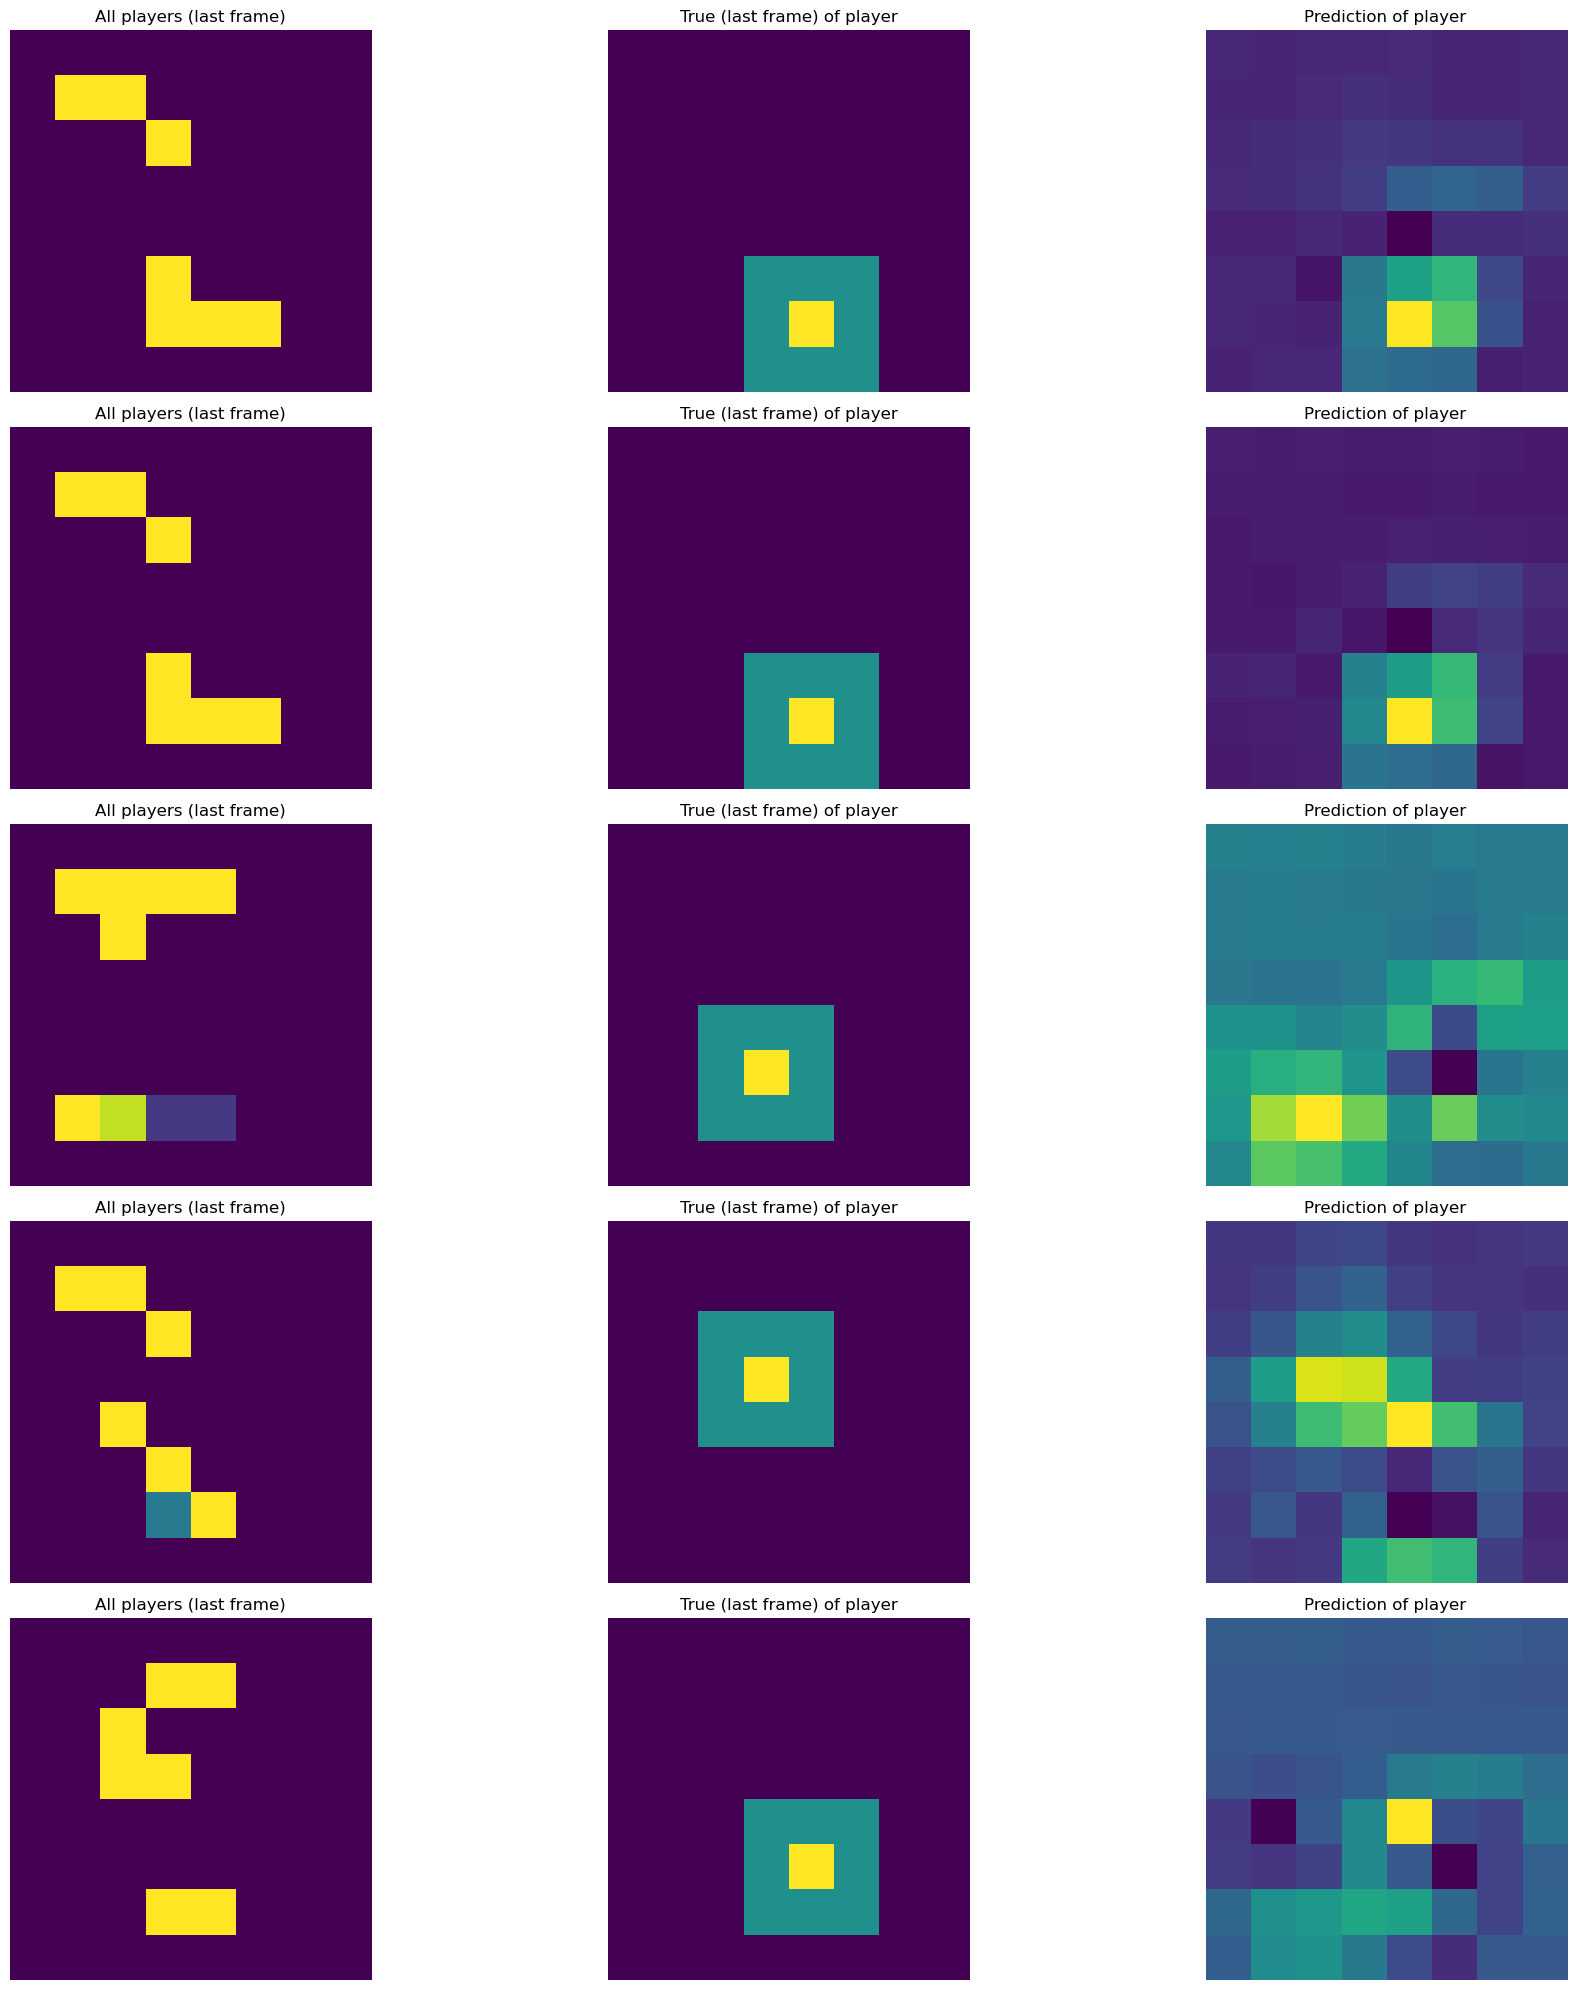

MODELO model1 - ESCENA Scene1
Epoch 1/50
20/20 [==============================] - 3s 52ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.0891 - val_loss: 0.0320 - val_mse: 0.0320 - val_mae: 0.0978
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.0926 - val_loss: 0.0295 - val_mse: 0.0295 - val_mae: 0.0966
Epoch 3/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.0871 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.0935
Epoch 4/50
20/20 [==============================] - 0s 20ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.0822 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae: 0.0909
Epoch 5/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.0793 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.0882
Epoch 6/50
20/20 [==============================] - 0s 20ms/step - loss: 0.0206 - mse: 0.0206 - mae: 0.0780 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae:

8/8 [==============================] - 1s 11ms/step


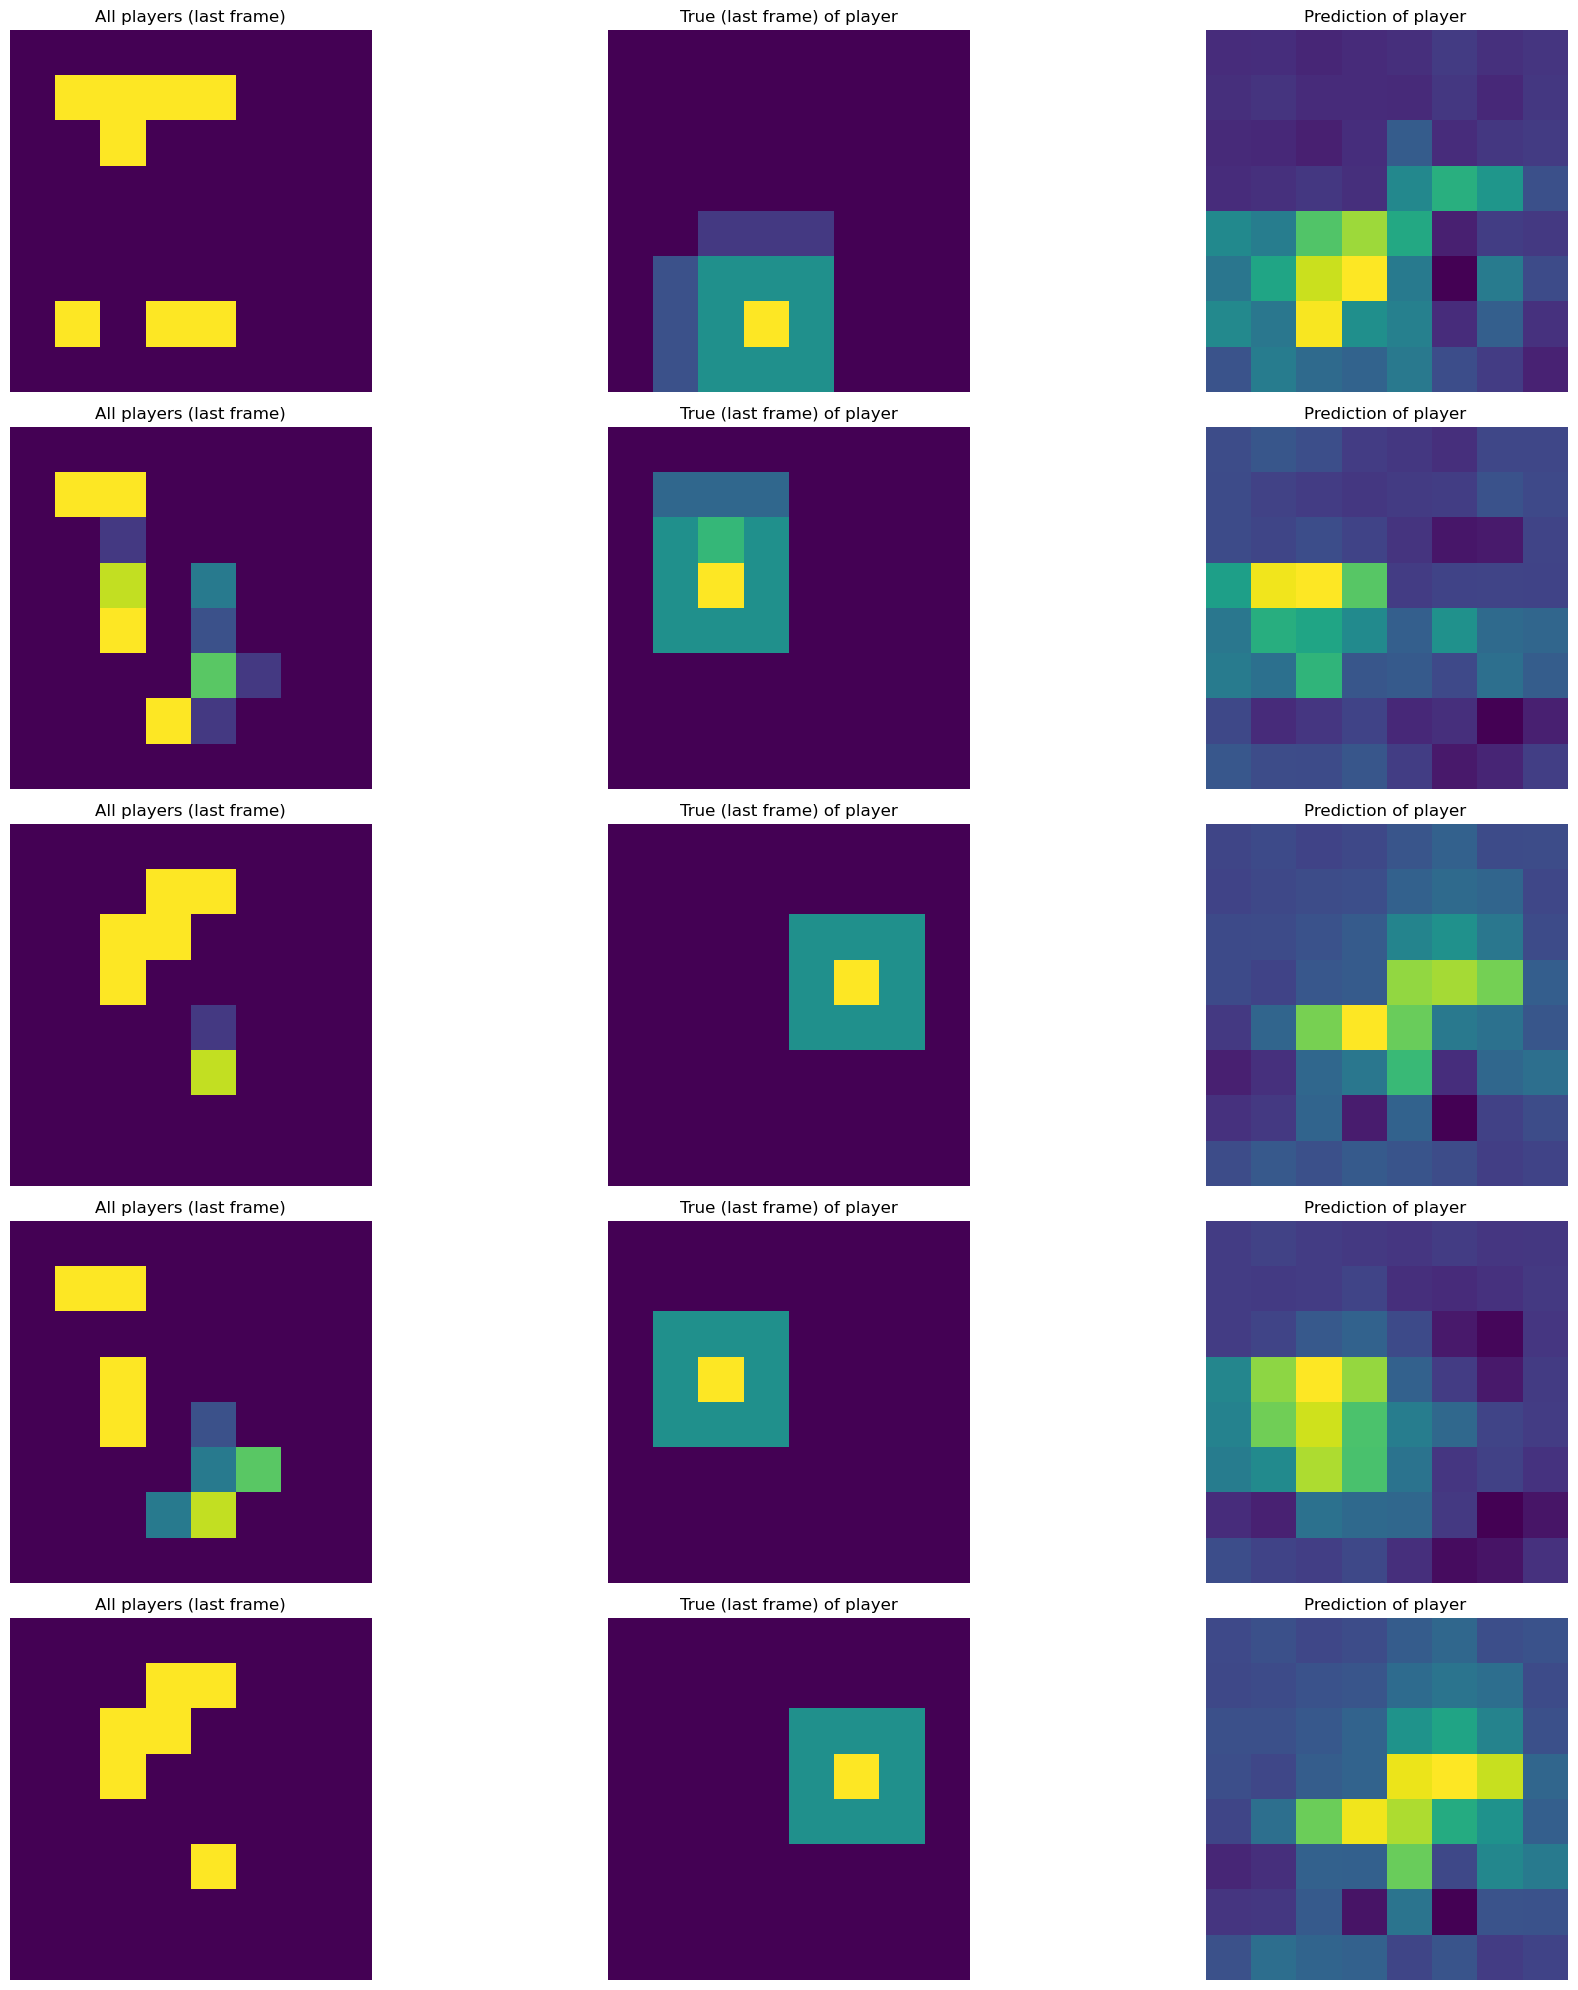

MODELO model2 - ESCENA Scene1
Epoch 1/50
20/20 [==============================] - 4s 87ms/step - loss: 0.0329 - mse: 0.0329 - mae: 0.0900 - val_loss: 0.0313 - val_mse: 0.0313 - val_mae: 0.1004
Epoch 2/50
20/20 [==============================] - 1s 50ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.0935 - val_loss: 0.0288 - val_mse: 0.0288 - val_mae: 0.0990
Epoch 3/50
20/20 [==============================] - 1s 48ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.0879 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.0931
Epoch 4/50
20/20 [==============================] - 1s 49ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.0822 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.0905
Epoch 5/50
20/20 [==============================] - 1s 49ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.0789 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.0898
Epoch 6/50
20/20 [==============================] - 1s 47ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.0768 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae:

8/8 [==============================] - 1s 12ms/step


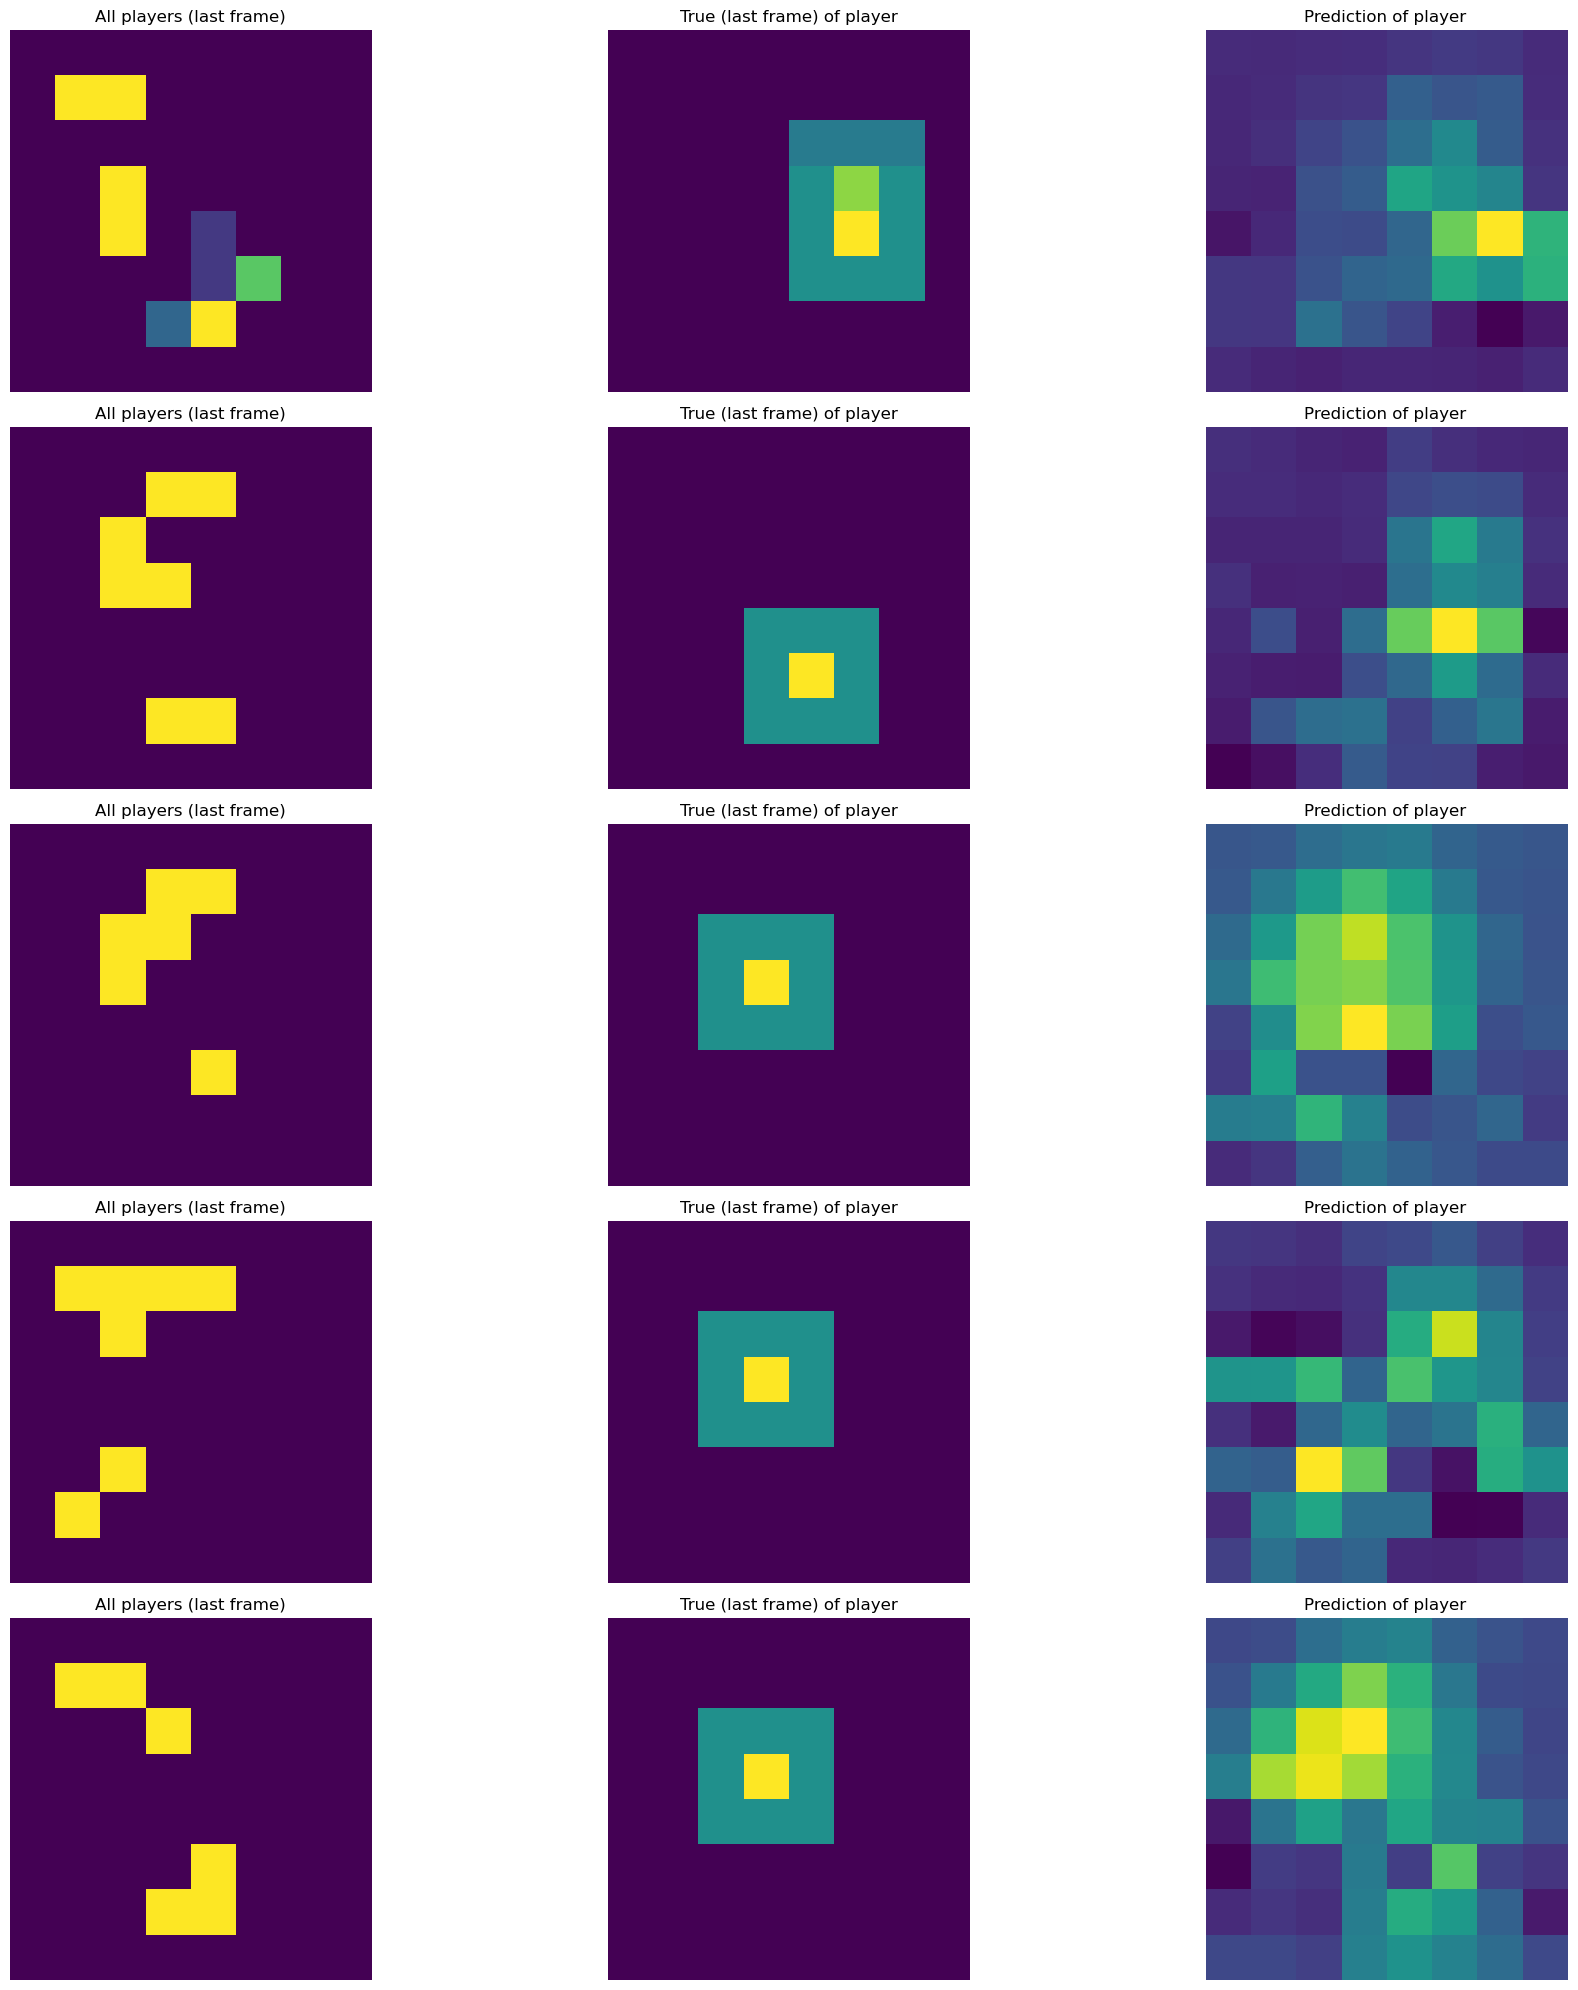

MODELO transf1 - ESCENA Scene1
Epoch 1/50
20/20 [==============================] - 23s 1s/step - loss: 0.0368 - mse: 0.0368 - mae: 0.1225 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1027
Epoch 2/50
20/20 [==============================] - 19s 984ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.0992 - val_loss: 0.0305 - val_mse: 0.0305 - val_mae: 0.1032
Epoch 3/50
20/20 [==============================] - 19s 957ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.0921 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.0990
Epoch 4/50
20/20 [==============================] - 20s 1s/step - loss: 0.0223 - mse: 0.0223 - mae: 0.0862 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.0956
Epoch 5/50
20/20 [==============================] - 20s 994ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.0833 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae: 0.0967
Epoch 6/50
20/20 [==============================] - 20s 991ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0800 - val_loss: 0.0285 - val_mse: 0.0285 - v

8/8 [==============================] - 5s 586ms/step


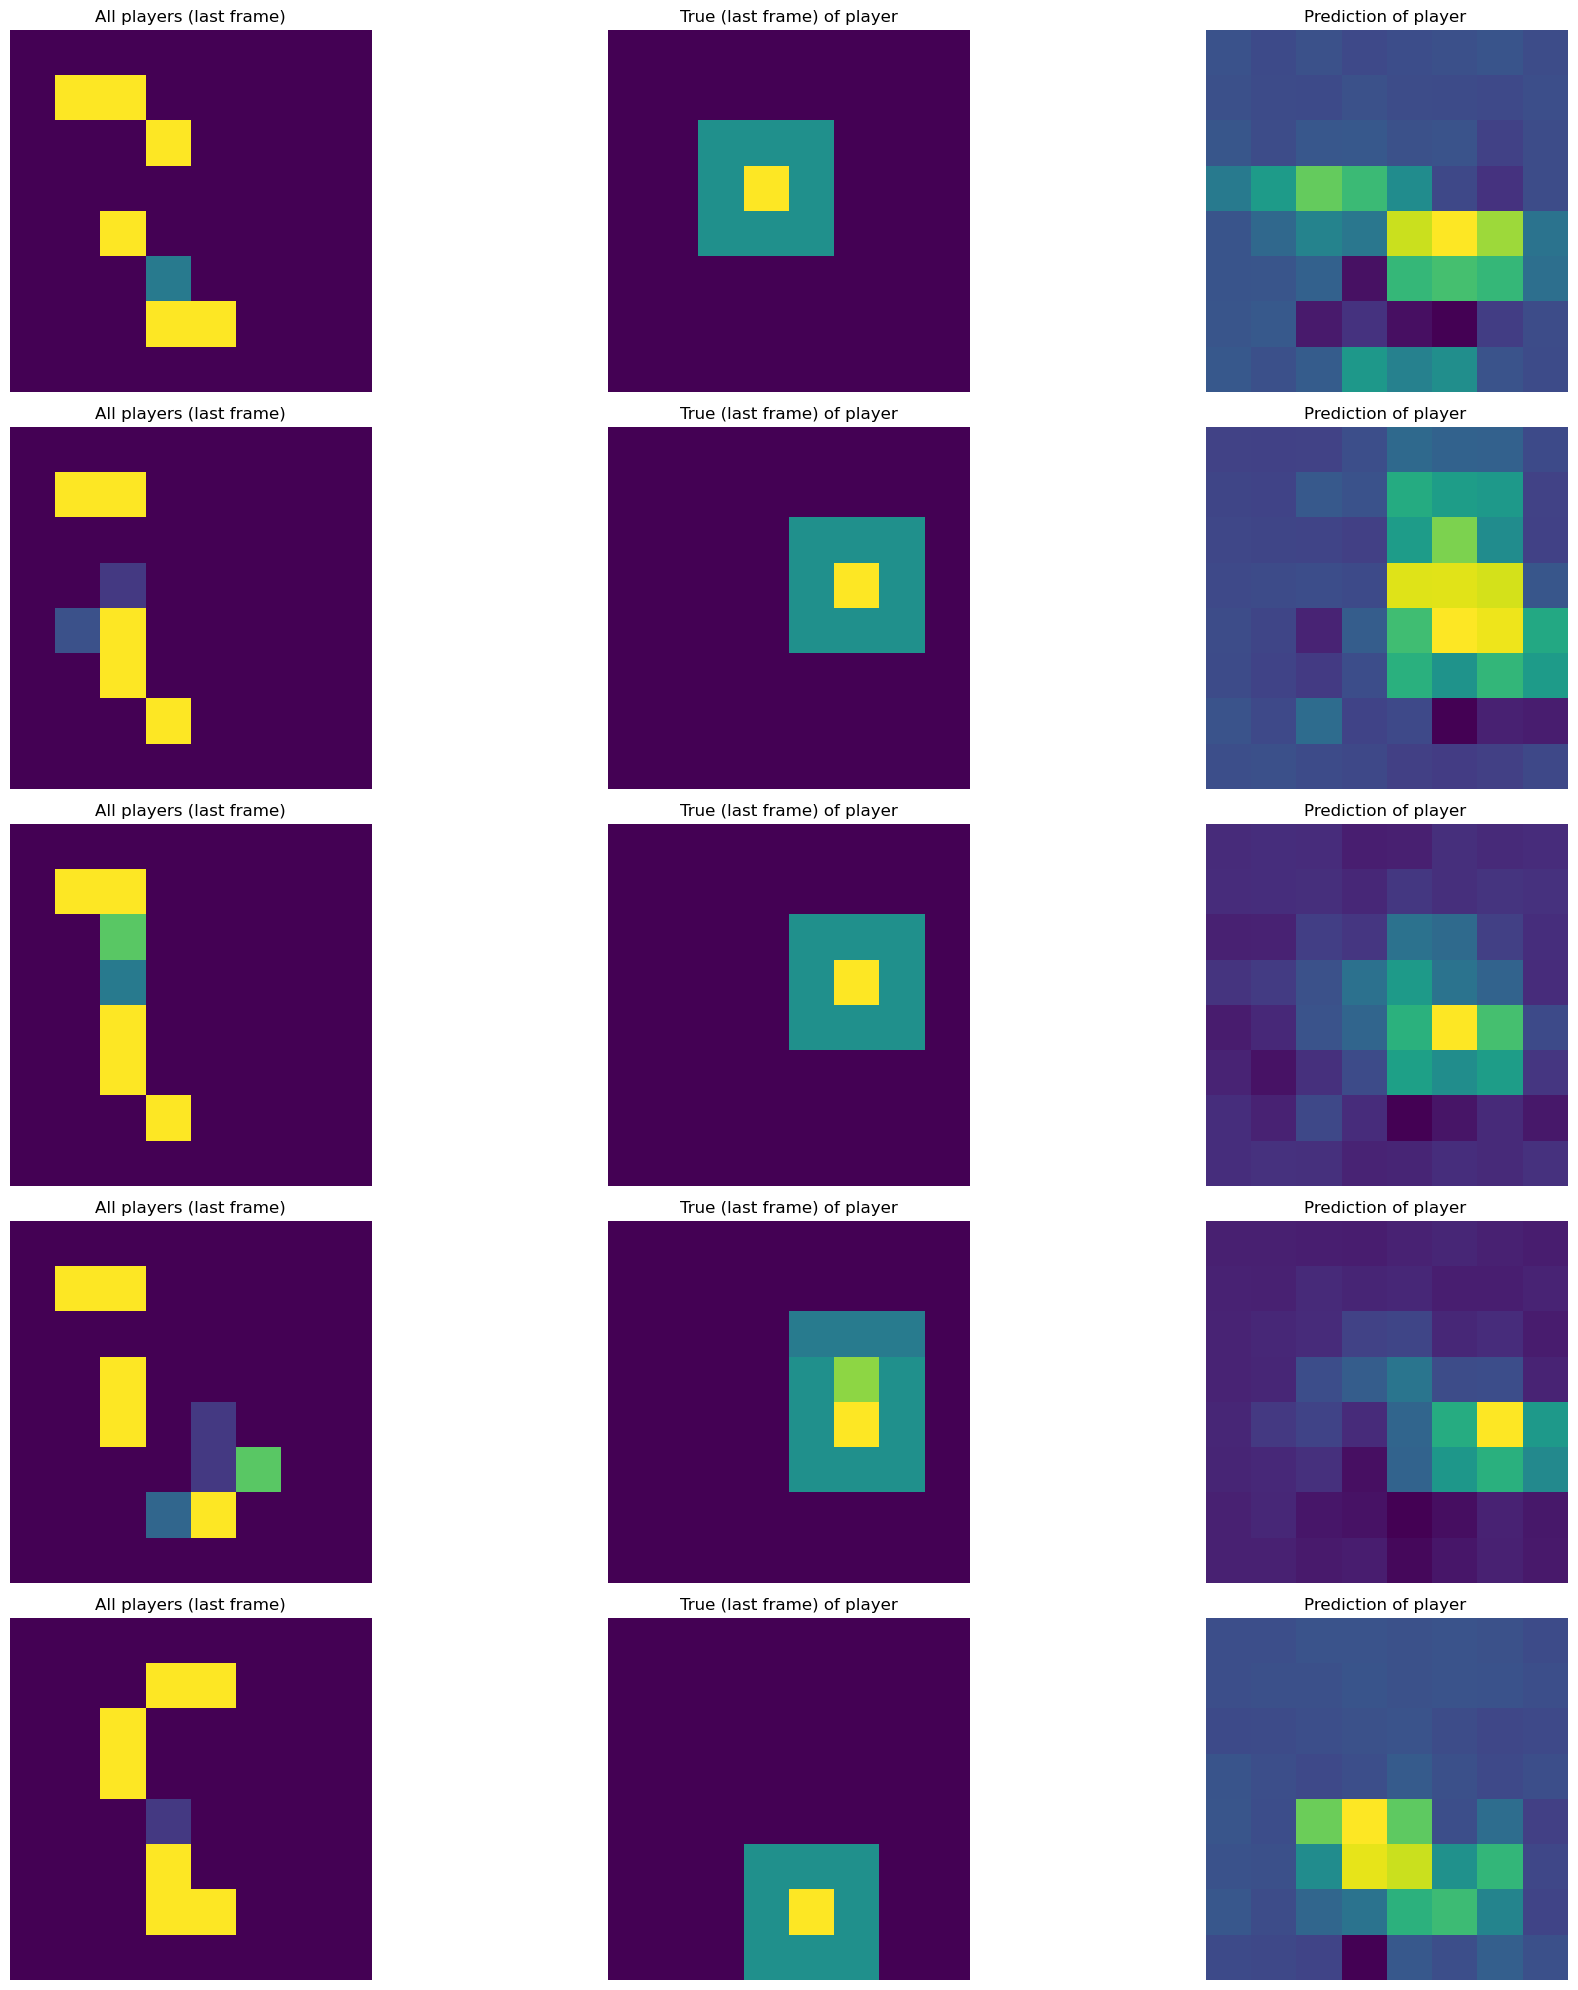

MODELO model0 - ESCENA Scene2
Epoch 1/50
16/16 [==============================] - 8s 125ms/step - loss: 0.0375 - mse: 0.0375 - mae: 0.0832 - val_loss: 0.0341 - val_mse: 0.0341 - val_mae: 0.1050
Epoch 2/50
16/16 [==============================] - 1s 72ms/step - loss: 0.0328 - mse: 0.0328 - mae: 0.1182 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1120
Epoch 3/50
16/16 [==============================] - 1s 69ms/step - loss: 0.0312 - mse: 0.0312 - mae: 0.1113 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1123
Epoch 4/50
16/16 [==============================] - 1s 67ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1052 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1041
Epoch 5/50
16/16 [==============================] - 1s 67ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.0998 - val_loss: 0.0304 - val_mse: 0.0304 - val_mae: 0.1046
Epoch 6/50
16/16 [==============================] - 1s 67ms/step - loss: 0.0263 - mse: 0.0263 - mae: 0.0933 - val_loss: 0.0297 - val_mse: 0.0297 - val_mae

10/10 [==============================] - 2s 71ms/step


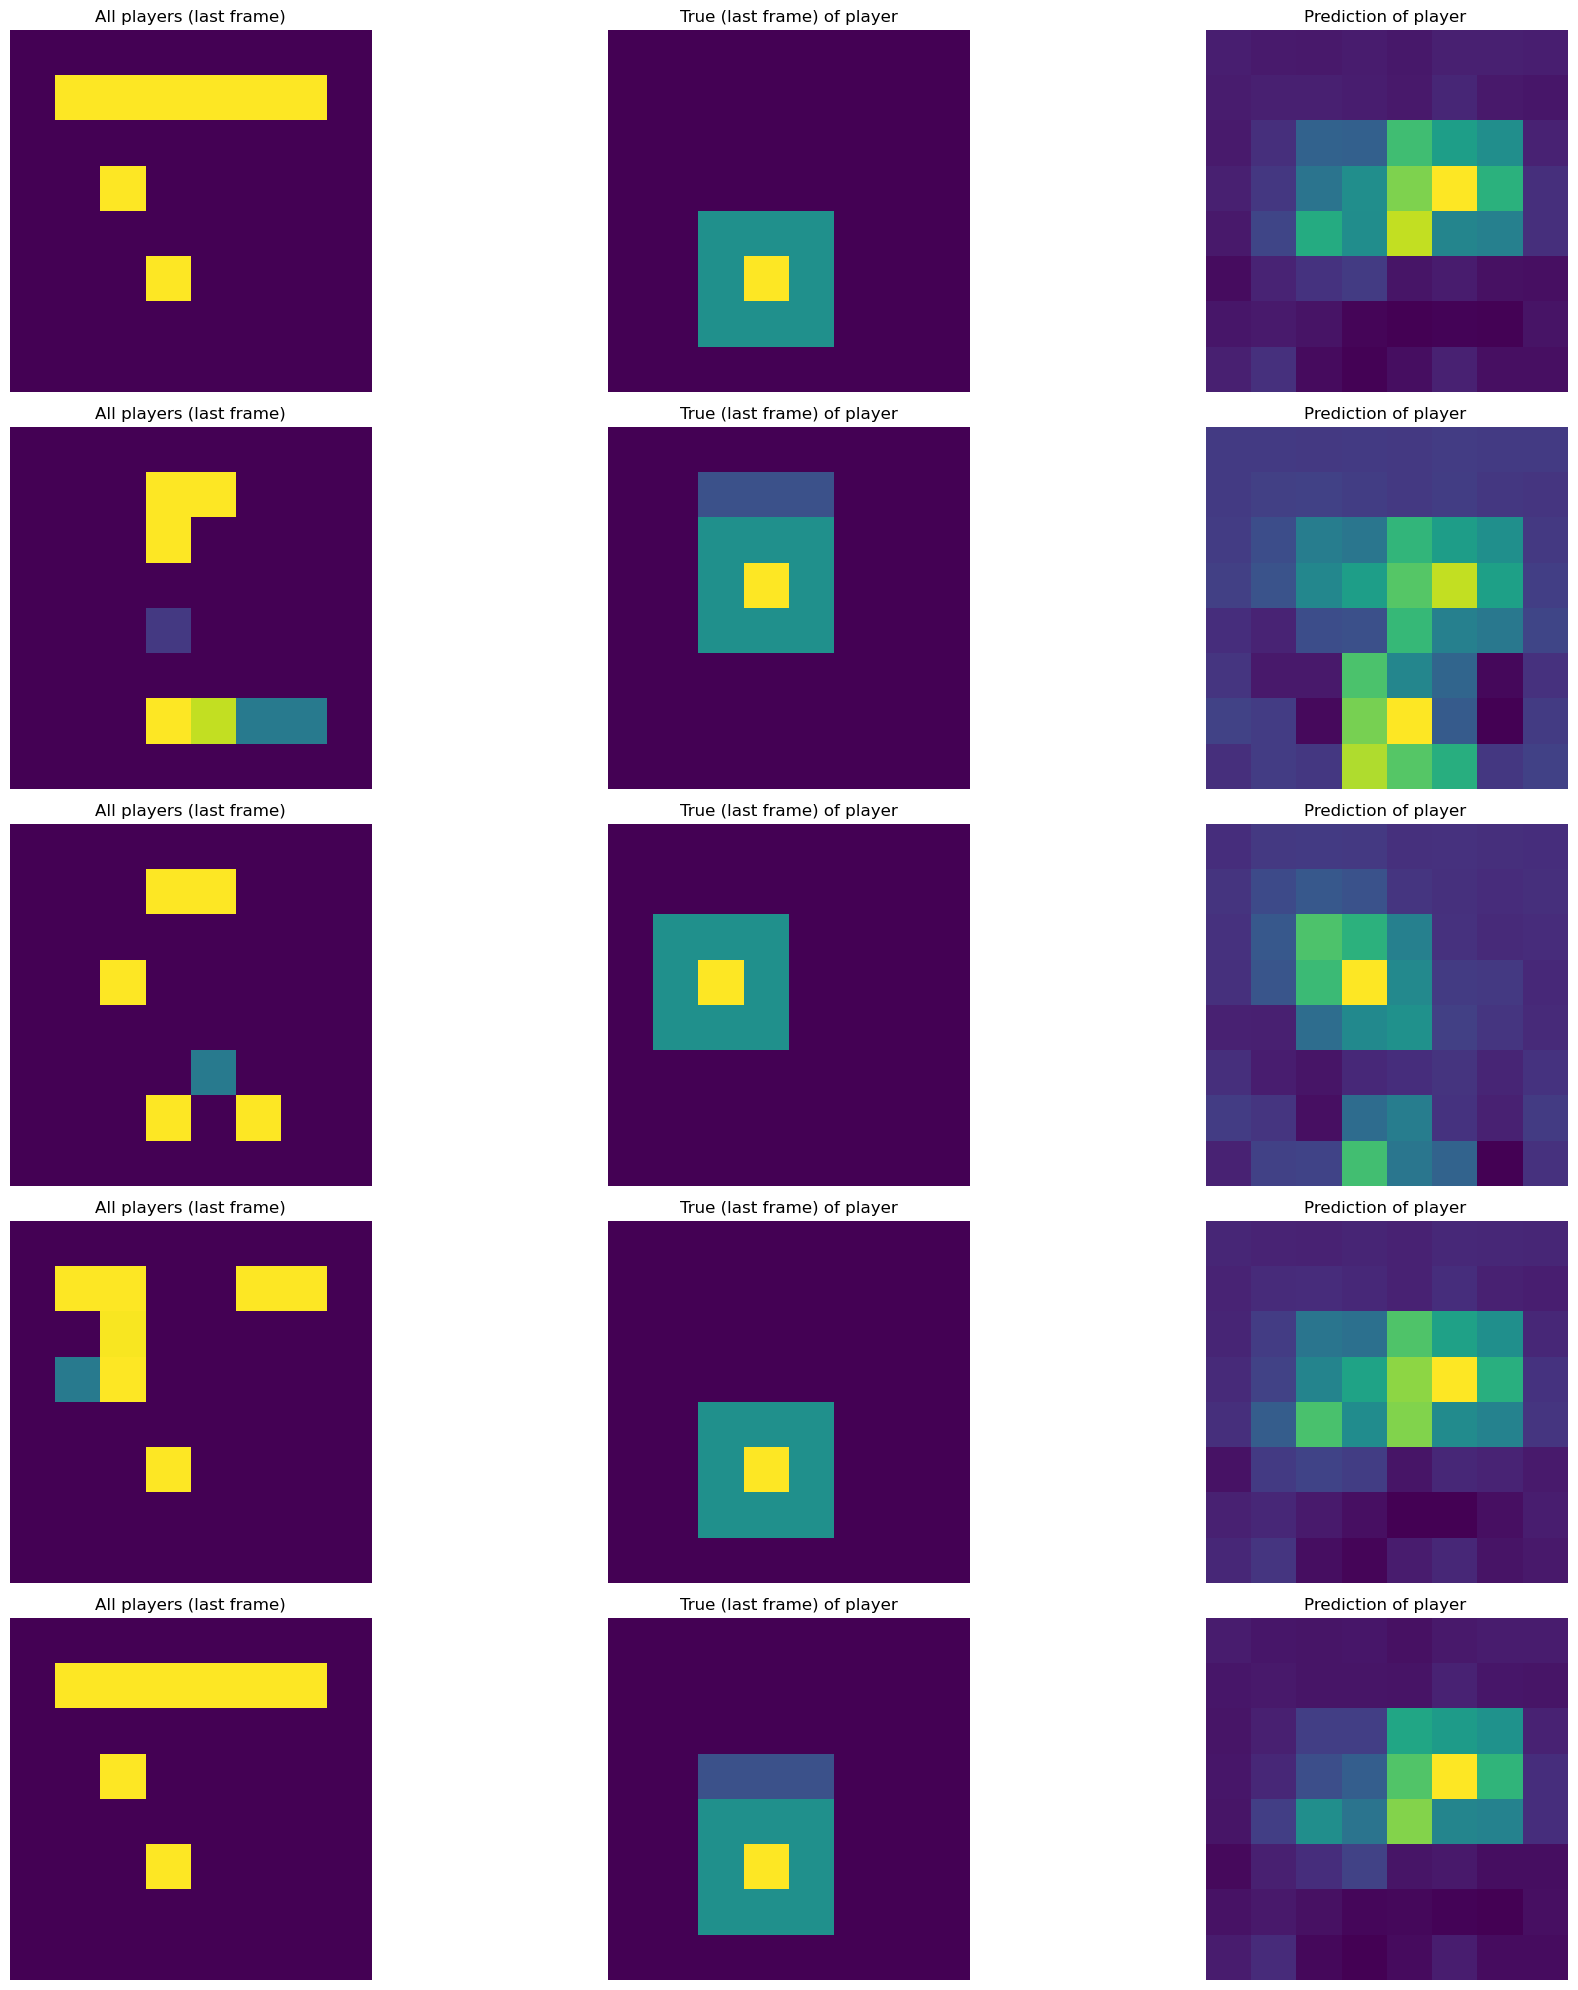

MODELO model1 - ESCENA Scene2
Epoch 1/50
16/16 [==============================] - 4s 129ms/step - loss: 0.0344 - mse: 0.0344 - mae: 0.0865 - val_loss: 0.0314 - val_mse: 0.0314 - val_mae: 0.0982
Epoch 2/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.0946 - val_loss: 0.0317 - val_mse: 0.0317 - val_mae: 0.1045
Epoch 3/50
16/16 [==============================] - 1s 88ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.0850 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.0978
Epoch 4/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0206 - mse: 0.0206 - mae: 0.0766 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.0946
Epoch 5/50
16/16 [==============================] - 1s 89ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.0739 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.0931
Epoch 6/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0720 - val_loss: 0.0313 - val_mse: 0.0313 - val_mae

10/10 [==============================] - 1s 19ms/step


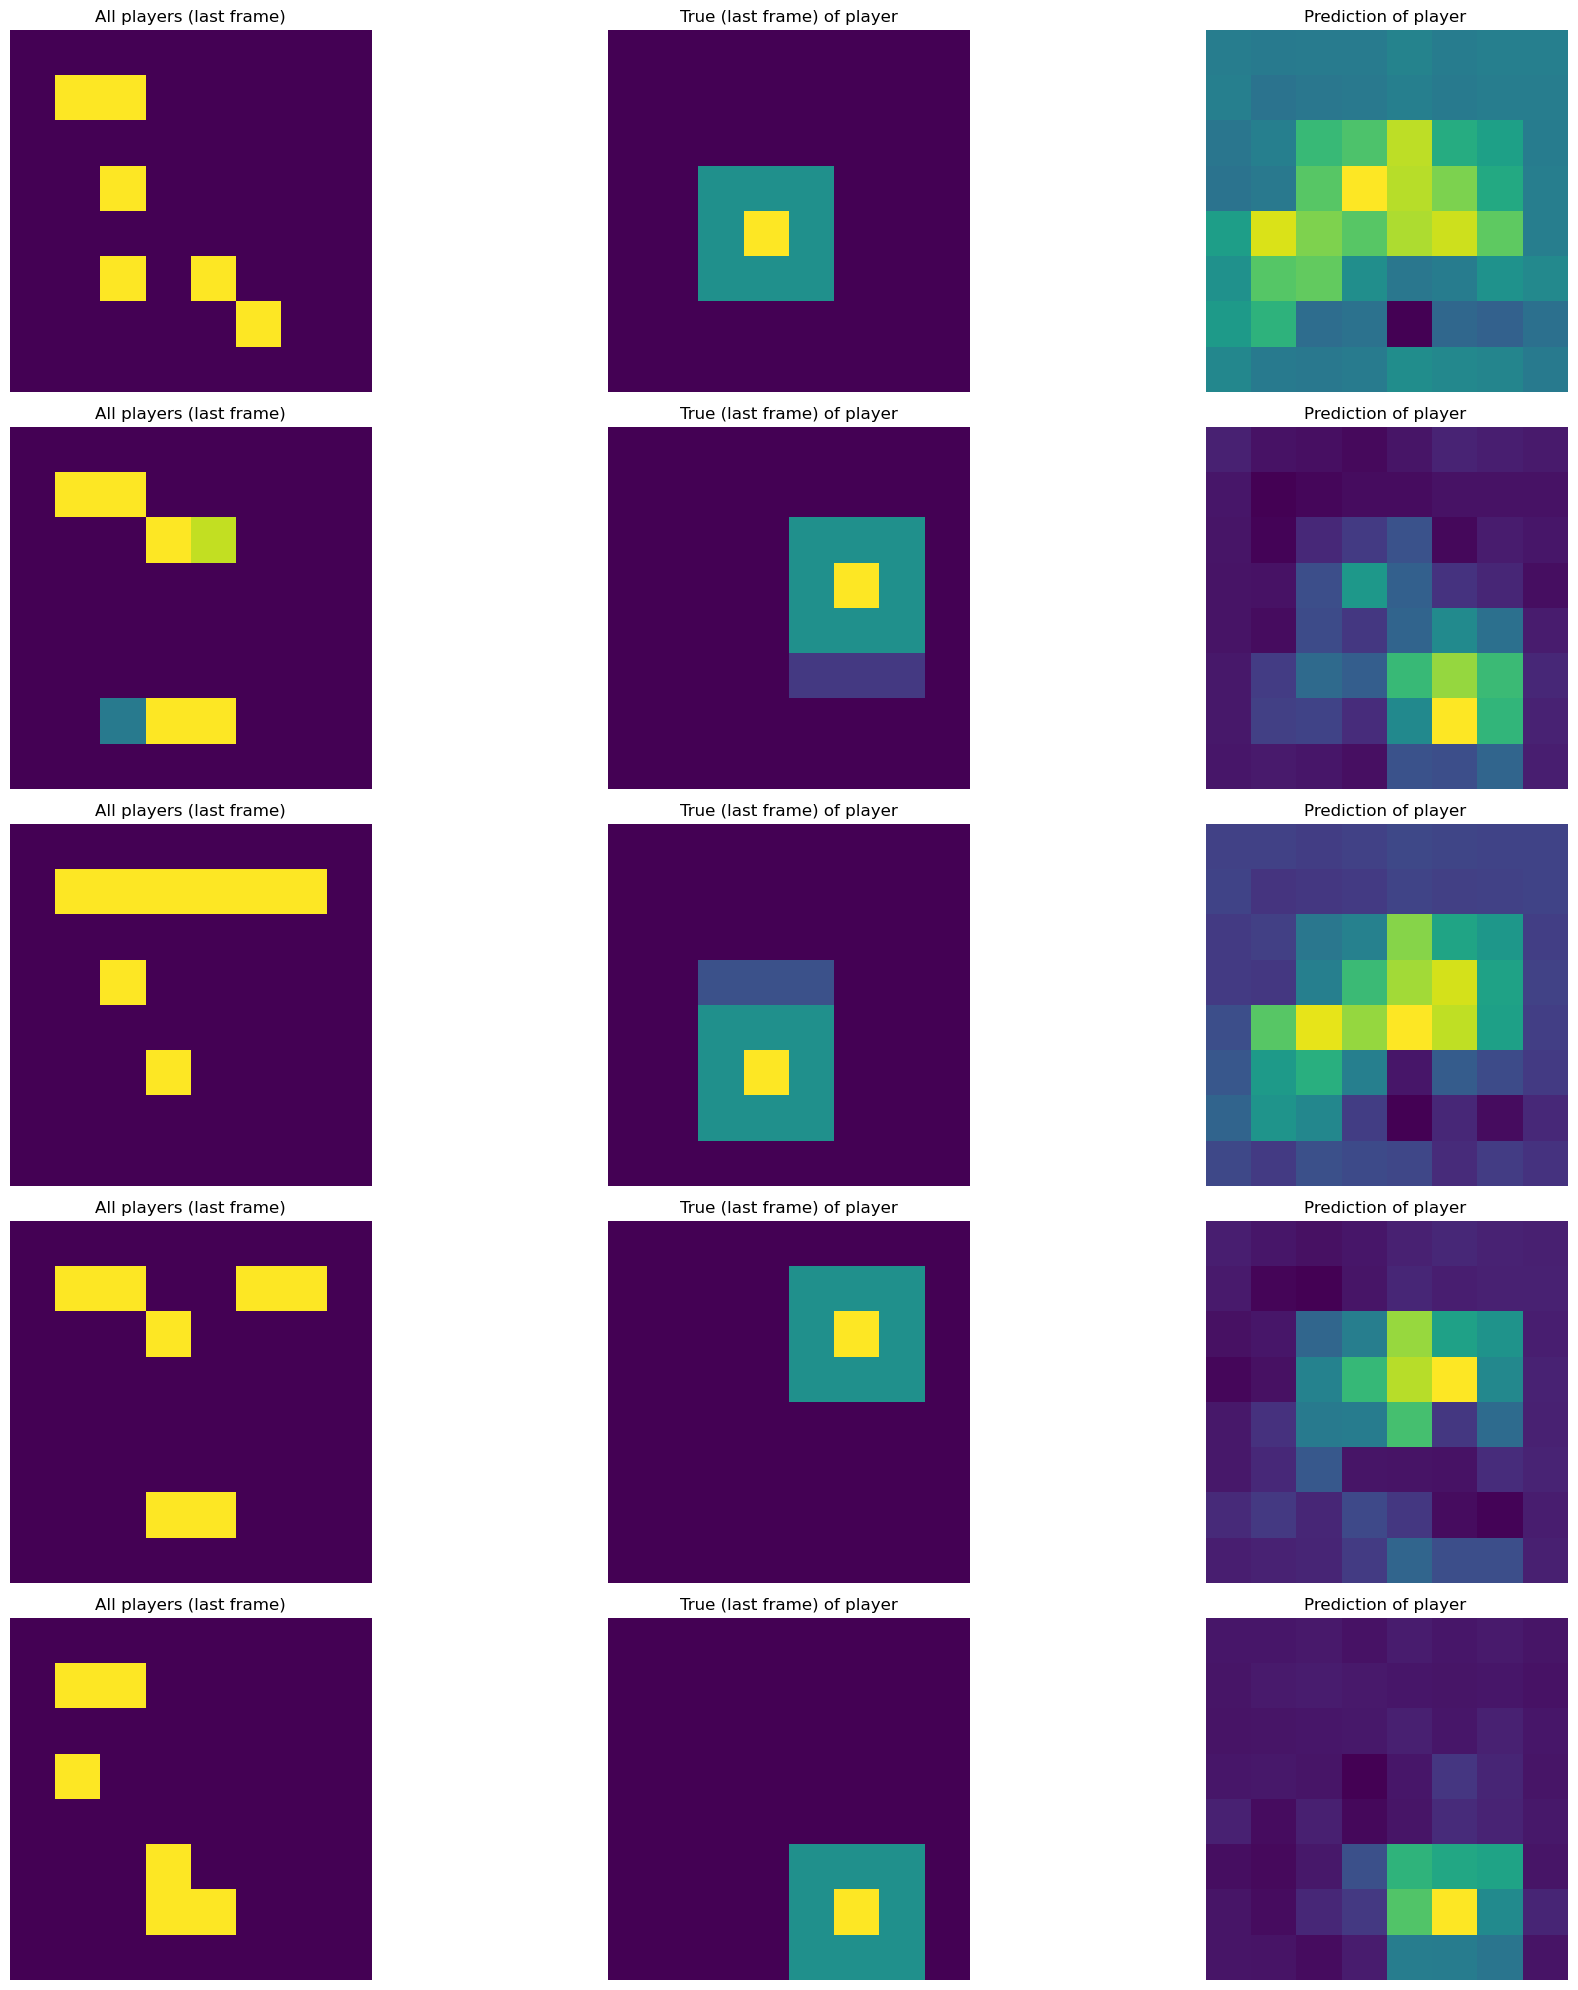

MODELO model2 - ESCENA Scene2
Epoch 1/50
16/16 [==============================] - 6s 216ms/step - loss: 0.0338 - mse: 0.0338 - mae: 0.0887 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.0927
Epoch 2/50
16/16 [==============================] - 3s 169ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.0934 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.1040
Epoch 3/50
16/16 [==============================] - 3s 171ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.0843 - val_loss: 0.0319 - val_mse: 0.0319 - val_mae: 0.0943
Epoch 4/50
16/16 [==============================] - 3s 170ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0765 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.0938
Epoch 5/50
16/16 [==============================] - 3s 170ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.0751 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.0930
Epoch 6/50
16/16 [==============================] - 3s 170ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.0731 - val_loss: 0.0326 - val_mse: 0.0326 - va

10/10 [==============================] - 1s 61ms/step


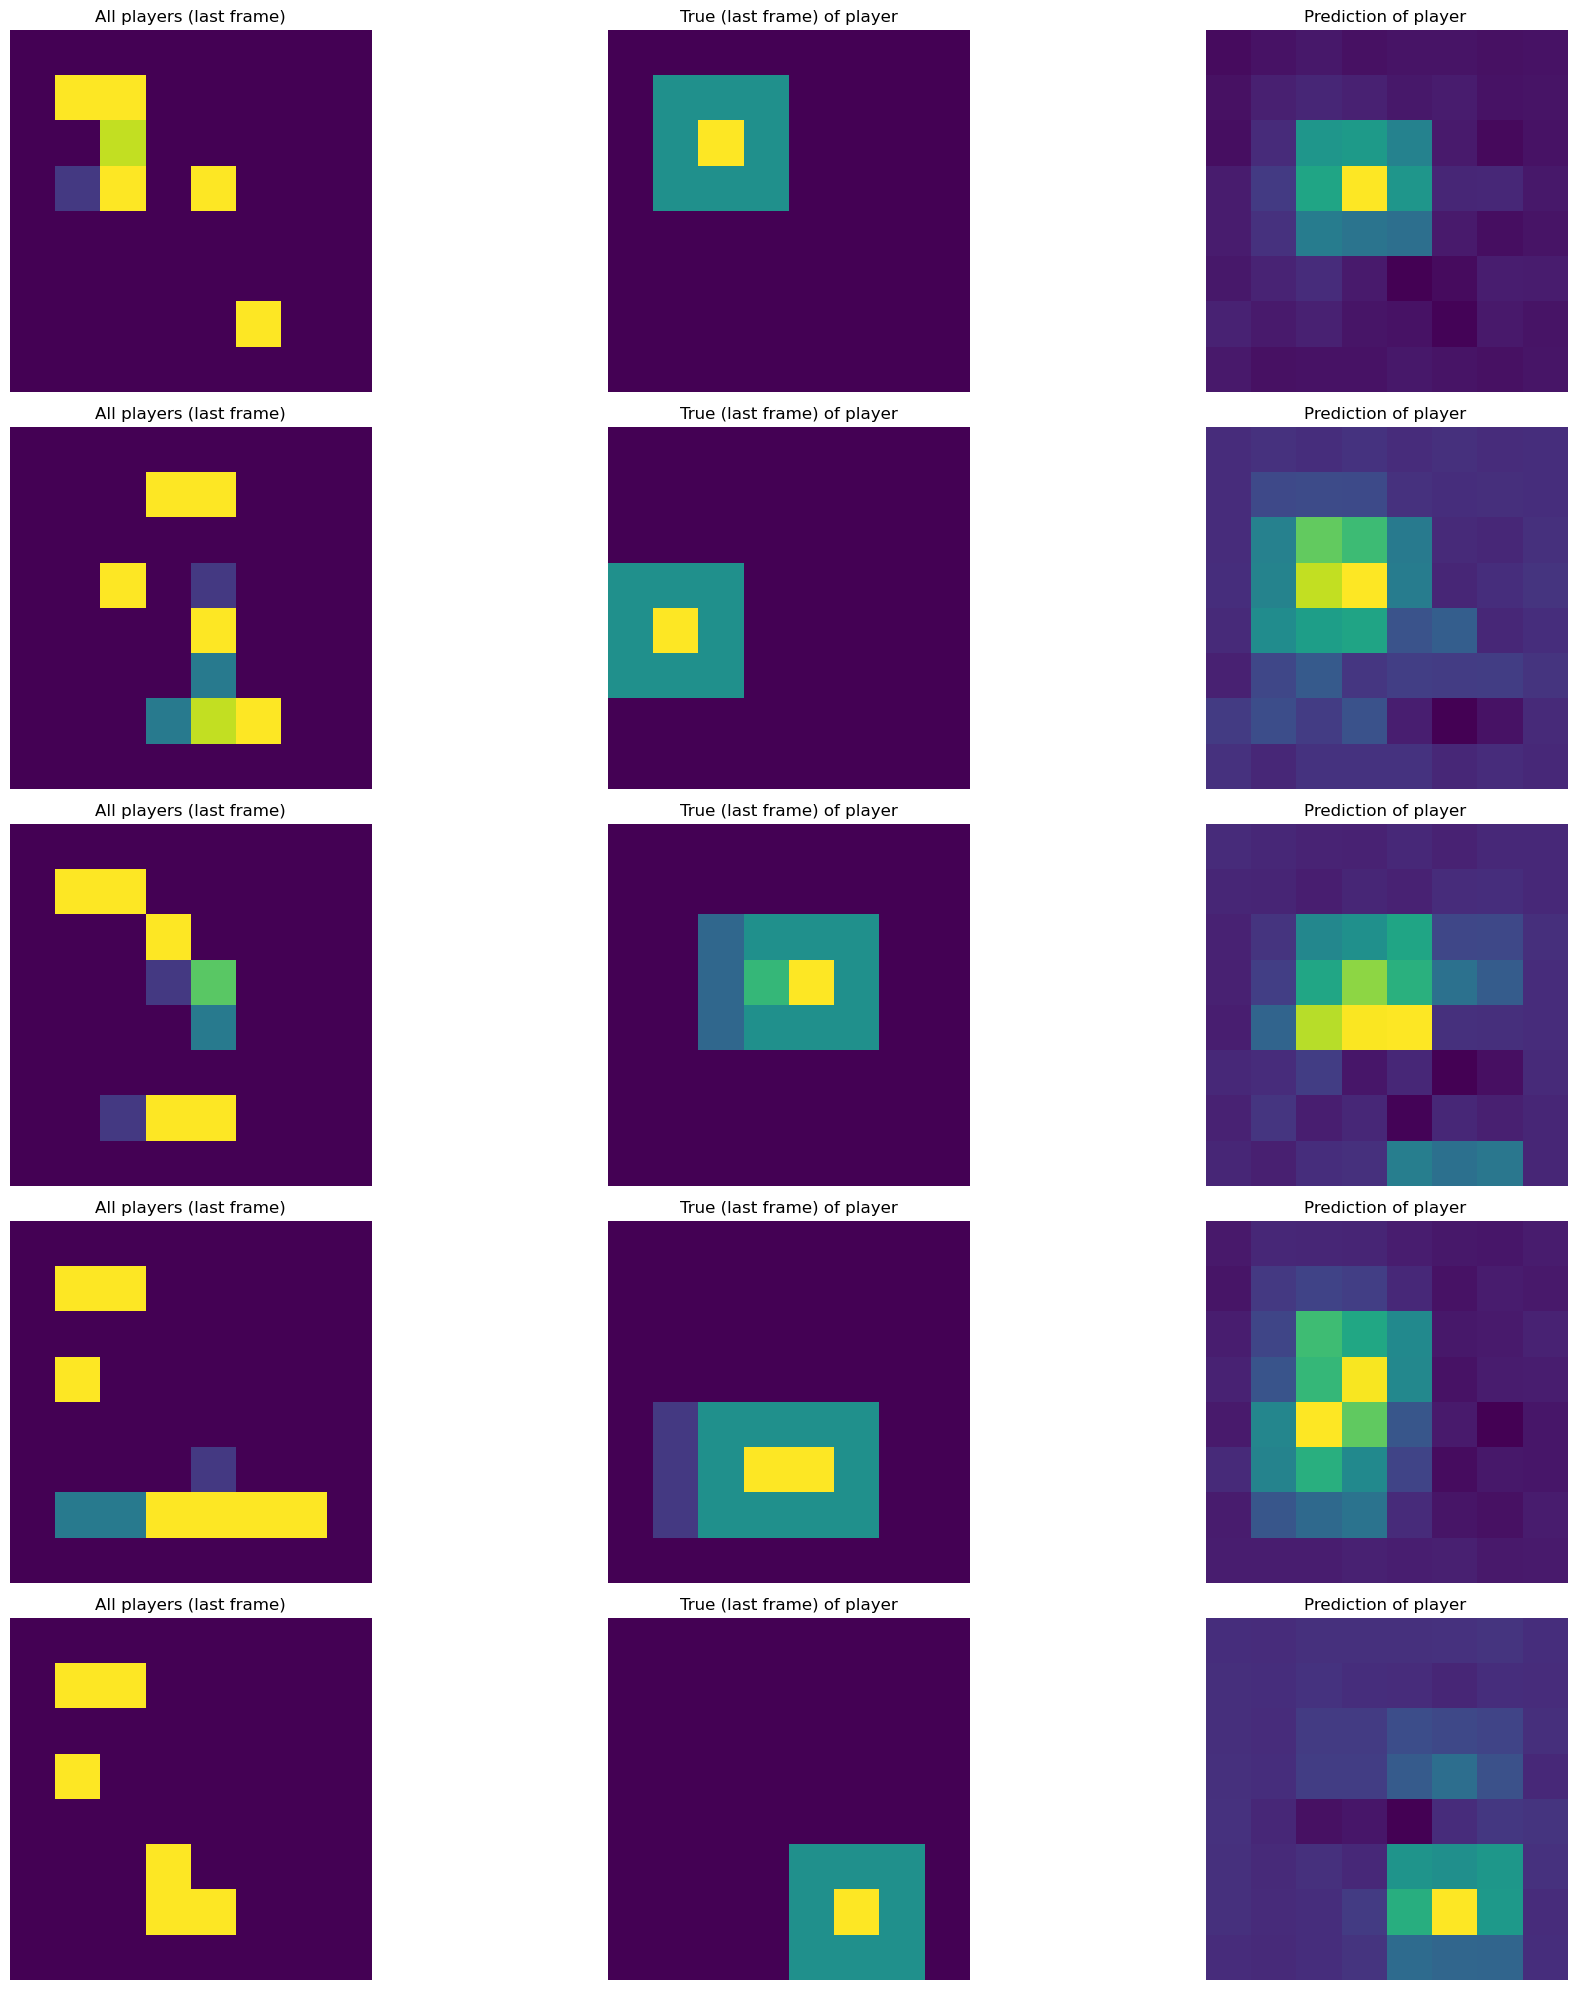

MODELO transf1 - ESCENA Scene2
Epoch 1/50
16/16 [==============================] - 27s 2s/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1228 - val_loss: 0.0378 - val_mse: 0.0378 - val_mae: 0.1234
Epoch 2/50
16/16 [==============================] - 25s 2s/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1025 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1078
Epoch 3/50
16/16 [==============================] - 25s 2s/step - loss: 0.0240 - mse: 0.0240 - mae: 0.0925 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.1055
Epoch 4/50
16/16 [==============================] - 25s 2s/step - loss: 0.0216 - mse: 0.0216 - mae: 0.0870 - val_loss: 0.0314 - val_mse: 0.0314 - val_mae: 0.1013
Epoch 5/50
16/16 [==============================] - 25s 2s/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0841 - val_loss: 0.0317 - val_mse: 0.0317 - val_mae: 0.1019
Epoch 6/50
16/16 [==============================] - 25s 2s/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0800 - val_loss: 0.0313 - val_mse: 0.0313 - val_mae: 0.09

10/10 [==============================] - 8s 818ms/step


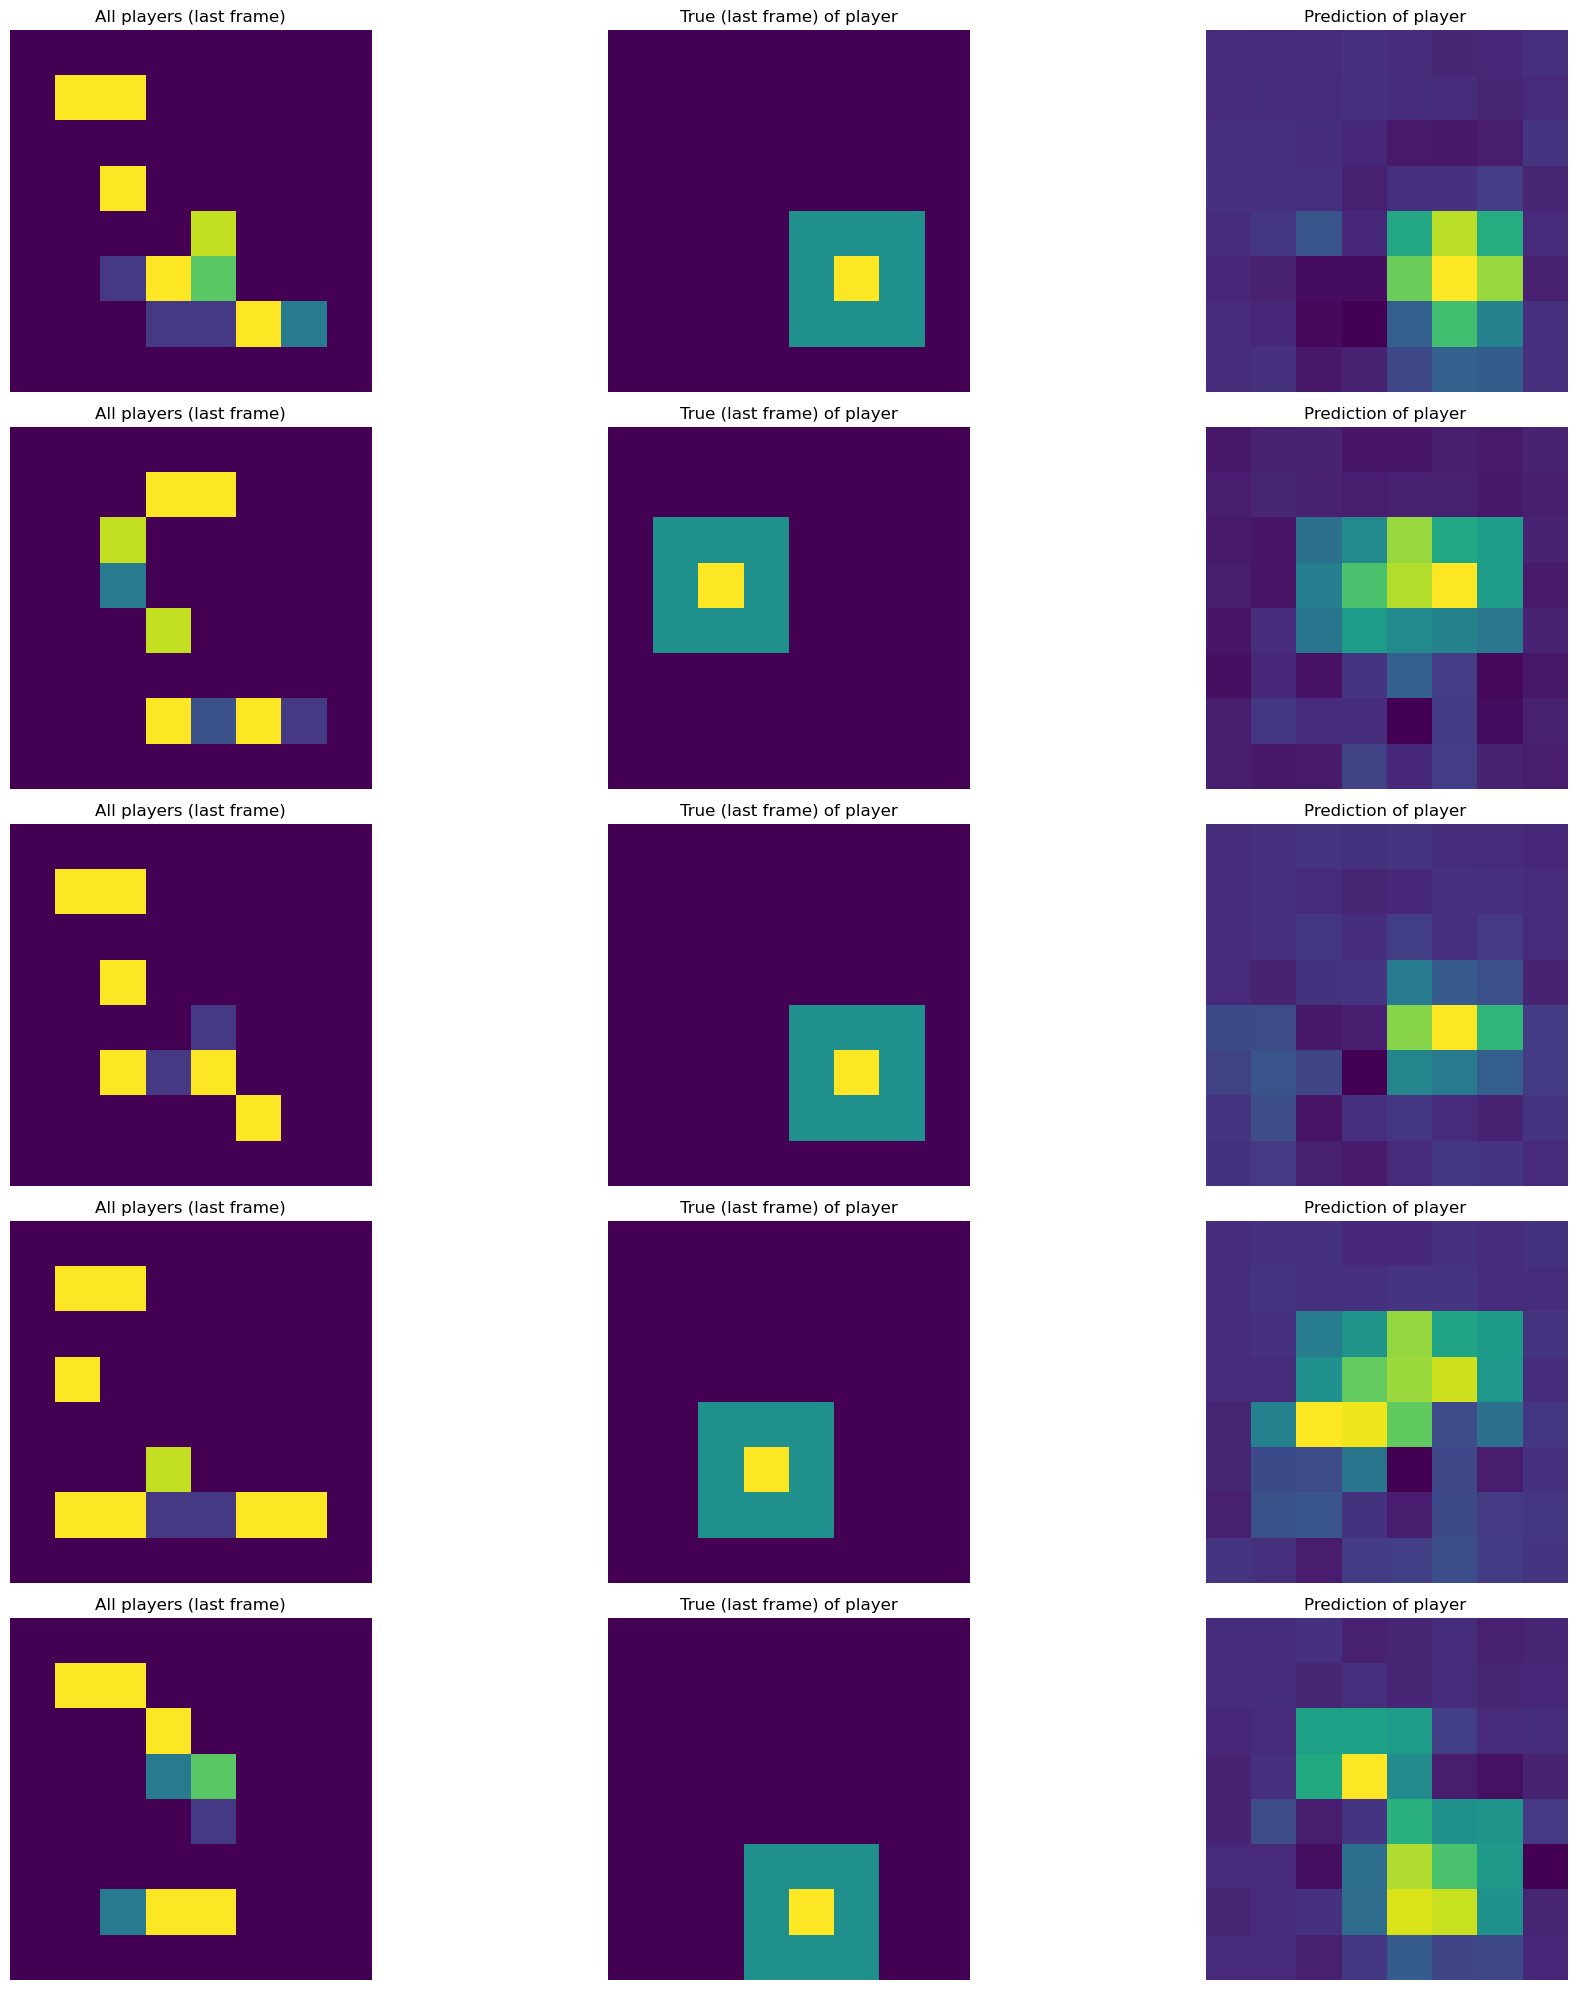

Resultados por escena:
Escena Scene1:
Modelo model0 - MSE: 0.0272, MAE: 0.0892, Tiempo: 42.92s
Modelo model1 - MSE: 0.0286, MAE: 0.0926, Tiempo: 22.14s
Modelo model2 - MSE: 0.0284, MAE: 0.0916, Tiempo: 51.12s
Modelo transf1 - MSE: 0.0285, MAE: 0.0860, Tiempo: 967.08s

Escena Scene2:
Modelo model0 - MSE: 0.0364, MAE: 0.1014, Tiempo: 59.43s
Modelo model1 - MSE: 0.0333, MAE: 0.0965, Tiempo: 73.95s
Modelo model2 - MSE: 0.0334, MAE: 0.0961, Tiempo: 138.50s
Modelo transf1 - MSE: 0.0361, MAE: 0.1000, Tiempo: 1245.46s

RESUMEN RESULTADOS:
Modelo model0:
Tiempo de ejecución total: 102.35 segundos
MSE promedio: 0.0318
MAE promedio: 0.0953

BCE promedio: 0.3333

Modelo model1:
Tiempo de ejecución total: 96.09 segundos
MSE promedio: 0.0309
MAE promedio: 0.0945

BCE promedio: 0.3192

Modelo model2:
Tiempo de ejecución total: 189.63 segundos
MSE promedio: 0.0309
MAE promedio: 0.0938

BCE promedio: 0.2999

Modelo transf1:
Tiempo de ejecución total: 2212.54 segundos
MSE promedio: 0.0323
MAE promedio: 

In [18]:
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss

# Assuming you have a function to calculate binary cross-entropy (log loss)
def binary_cross_entropy(y_true, y_pred):
    """
    Calcula la Binary Cross-Entropy (BCE) asegurando que y_true y y_pred sean válidos.
    Soporta etiquetas no binarias (soft labels).
    """
    # Asegurar que los valores de y_pred estén entre 0 y 1
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Asegurar que los valores de y_true estén en el rango [0,1]
    y_true = np.clip(y_true, 0, 1)

    # Fórmula BCE: -(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
    bce = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(bce)

np.random.seed(42)

# Lista de identificadores de modelo
model_ids = ["model0","model1","model2","transf1"] 


# Estructuras para almacenar resultados y tiempos de ejecución
mse_results = {model_id: [] for model_id in model_ids}
bce_results = {model_id: [] for model_id in model_ids} #binary cross entropy
mae_results = {model_id: [] for model_id in model_ids}
training_times = {model_id: [] for model_id in model_ids}
total_execution_time = {model_id: 0 for model_id in model_ids}

print(np.unique(S))

escenas_seleccionadas=np.unique(S)
#escenas_seleccionadas=escenas_seleccionadas[3:]
print("Para esta ejecución se han seleccionada las escenas: ")
print(escenas_seleccionadas)

for ixs, sc in enumerate(escenas_seleccionadas):
    # Índices para entrenamiento y prueba
    train_indices = np.where(S != sc)[0]
    test_indices = np.where(S == sc)[0]
    np.random.shuffle(train_indices)

    XYT_train = XYT[train_indices]
    rssiT_train = rssiT[train_indices]
    YT_train = YT[train_indices]

    XYT_test = XYT[test_indices]
    rssiT_test = rssiT[test_indices]
    YT_test = YT[test_indices]
    
    for model_id in model_ids:
        print(f"MODELO {model_id} - ESCENA {sc}")
        
        model = load_model(f"{model_id}.h5")

        start_time = time.time()

        history = model.fit([XYT_train, rssiT_train], YT_train,
                                  batch_size=16,
                                  validation_data=([XYT_test, rssiT_test], YT_test),
                                  epochs=50)
        end_time = time.time()
        training_time = end_time - start_time
        
        YT_prediction = model.predict([XYT_test, rssiT_test])

        plottingRandom(XYT_test, YT_test, YT_prediction)

        mse = mean_squared_error(YT_test.flatten(), YT_prediction.flatten())
        mae = mean_absolute_error(YT_test.flatten(), YT_prediction.flatten())
        bce = binary_cross_entropy(YT_test.flatten(), YT_prediction.flatten())

        mse_results[model_id].append(mse)
        mae_results[model_id].append(mae)
        bce_results[model_id].append(bce)
        
       
        training_times[model_id].append(training_time)
        total_execution_time[model_id] += training_time

# Calculando promedios y mostrando resultados

print("Resultados por escena:")
for i, sc in enumerate(escenas_seleccionadas):
    print(f"Escena {sc}:")
    for model_id in model_ids:
        print(f"Modelo {model_id} - MSE: {mse_results[model_id][i]:.4f}, MAE: {mae_results[model_id][i]:.4f}, Tiempo: {training_times[model_id][i]:.2f}s")
    print("")
    
print("RESUMEN RESULTADOS:")
for model_id in model_ids:
    average_mse = np.mean(mse_results[model_id])
    average_mae = np.mean(mae_results[model_id])
    average_bce = np.mean(bce_results[model_id])
    print(f"Modelo {model_id}:")
    print(f"Tiempo de ejecución total: {total_execution_time[model_id]:.2f} segundos")
    print(f"MSE promedio: {average_mse:.4f}")
    print(f"MAE promedio: {average_mae:.4f}\n")
    print(f"BCE promedio: {average_bce:.4f}\n")


In [19]:
ts.sort()
print(ts)

[1710621078, 1710621079, 1710621080, 1710621081, 1710621082, 1710621083, 1710621084, 1710621085, 1710621086, 1710621087, 1710621088, 1710621089, 1710621090, 1710621091, 1710621092, 1710621093, 1710621094, 1710621095, 1710621096, 1710621097, 1710621098, 1710621099, 1710621100, 1710621101, 1710621102, 1710621103, 1710621104, 1710621105, 1710621106, 1710621107, 1710621108, 1710621109, 1710621110, 1710621111, 1710621112, 1710621113, 1710621114, 1710621115, 1710621116, 1710621117, 1710621118, 1710621119, 1710621120, 1710621121, 1710621122, 1710621123, 1710621124, 1710621125, 1710621126, 1710621127, 1710621128, 1710621129, 1710621130, 1710621131, 1710621132, 1710621133, 1710621134, 1710621135, 1710621136, 1710621137, 1710621138, 1710621139, 1710621140, 1710621141, 1710621142, 1710621143, 1710621144, 1710621145, 1710621146, 1710621147, 1710621148, 1710621149, 1710621150, 1710621151, 1710621152, 1710621153, 1710621154, 1710621155, 1710621156, 1710621157, 1710621158, 1710621159, 1710621160, 171